### TFG AÑO- Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de año a año (252 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testAño.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testAño.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testAño.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testAño.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [6]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



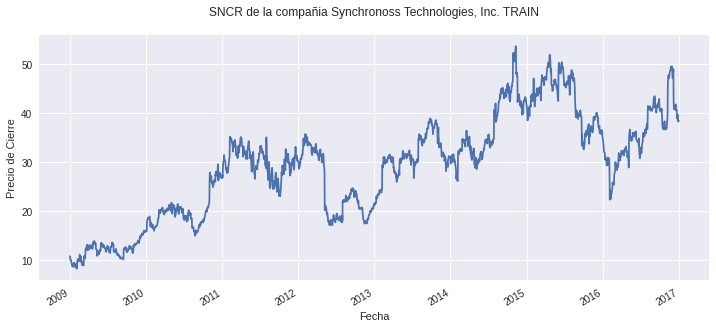

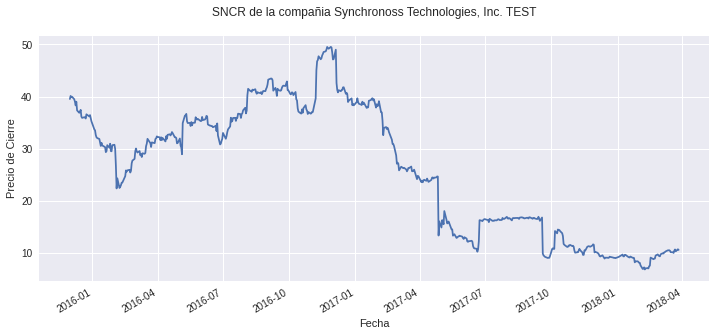

In [7]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 1
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [8]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [9]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo SNCR de la compañia Synchronoss Technologies, Inc.


In [10]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

# Creacion de la red neural LSTM

In [21]:
model42 = Sequential()
model42.add(LSTM(4, input_shape=(252,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 4)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 13s 360ms/step - loss: 1097.6162 - porcentaje_margen: 0.0000e+00 - val_loss: 1078.8767 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 12s 323ms/step - loss: 1091.9728 - porcentaje_margen: 0.0000e+00 - val_loss: 1071.7588 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==============

37/37 [==============================] - 13s 358ms/step - loss: 560.5995 - porcentaje_margen: 0.0000e+00 - val_loss: 546.0378 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 13s 358ms/step - loss: 556.1969 - porcentaje_margen: 0.0000e+00 - val_loss: 541.6650 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 13s 350ms/step - loss: 551.8221 - porcentaje_margen: 0.0000e+00 - val_loss: 537.3646 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 13s 355ms/step - loss: 547.4869 - porcentaje_margen: 0.0000e+00 - val_loss: 533.0782 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 13s 356ms/step - loss: 543.1525 - porcentaje_margen: 0.0000e+00 - val_loss: 528.7901 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 13s 356ms/step - loss: 538.8479 - porcentaje_margen: 0.0000e+00 - val_loss: 524

37/37 [==============================] - 12s 330ms/step - loss: 245.0101 - porcentaje_margen: 0.0701 - val_loss: 234.9531 - val_porcentaje_margen: 0.0576
Epoch 184/1500
37/37 [==============================] - 12s 332ms/step - loss: 242.6304 - porcentaje_margen: 0.0650 - val_loss: 232.6455 - val_porcentaje_margen: 0.0576
Epoch 185/1500
37/37 [==============================] - 12s 335ms/step - loss: 240.2981 - porcentaje_margen: 0.0633 - val_loss: 230.3384 - val_porcentaje_margen: 0.0664
Epoch 186/1500
37/37 [==============================] - 12s 336ms/step - loss: 237.9778 - porcentaje_margen: 0.0659 - val_loss: 228.0474 - val_porcentaje_margen: 0.0697
Epoch 187/1500
37/37 [==============================] - 12s 330ms/step - loss: 235.6694 - porcentaje_margen: 0.0684 - val_loss: 225.8053 - val_porcentaje_margen: 0.0681
Epoch 188/1500
37/37 [==============================] - 12s 336ms/step - loss: 233.3738 - porcentaje_margen: 0.0667 - val_loss: 223.5753 - val_porcentaje_margen: 0.0763
E

37/37 [==============================] - 13s 344ms/step - loss: 100.8080 - porcentaje_margen: 0.0684 - val_loss: 94.7126 - val_porcentaje_margen: 0.0592
Epoch 280/1500
37/37 [==============================] - 13s 350ms/step - loss: 100.0925 - porcentaje_margen: 0.0709 - val_loss: 94.0225 - val_porcentaje_margen: 0.0609
Epoch 281/1500
37/37 [==============================] - 13s 349ms/step - loss: 99.3851 - porcentaje_margen: 0.0693 - val_loss: 93.3558 - val_porcentaje_margen: 0.0674
Epoch 282/1500
37/37 [==============================] - 13s 353ms/step - loss: 98.7022 - porcentaje_margen: 0.0743 - val_loss: 92.6915 - val_porcentaje_margen: 0.0691
Epoch 283/1500
37/37 [==============================] - 13s 352ms/step - loss: 98.0173 - porcentaje_margen: 0.0693 - val_loss: 92.0631 - val_porcentaje_margen: 0.0724
Epoch 284/1500
37/37 [==============================] - 13s 357ms/step - loss: 97.3595 - porcentaje_margen: 0.0726 - val_loss: 91.4450 - val_porcentaje_margen: 0.0757
Epoch 285/1

37/37 [==============================] - 12s 327ms/step - loss: 28.5339 - porcentaje_margen: 0.4637 - val_loss: 26.5993 - val_porcentaje_margen: 0.4865
Epoch 378/1500
37/37 [==============================] - 12s 326ms/step - loss: 28.0939 - porcentaje_margen: 0.4569 - val_loss: 26.2695 - val_porcentaje_margen: 0.4727
Epoch 379/1500
37/37 [==============================] - 12s 326ms/step - loss: 27.6933 - porcentaje_margen: 0.4578 - val_loss: 25.9062 - val_porcentaje_margen: 0.4480
Epoch 380/1500
37/37 [==============================] - 12s 333ms/step - loss: 27.3118 - porcentaje_margen: 0.4620 - val_loss: 25.5114 - val_porcentaje_margen: 0.4799
Epoch 381/1500
37/37 [==============================] - 12s 326ms/step - loss: 26.8997 - porcentaje_margen: 0.4789 - val_loss: 25.1021 - val_porcentaje_margen: 0.4938
Epoch 382/1500
37/37 [==============================] - 12s 324ms/step - loss: 26.5150 - porcentaje_margen: 0.4637 - val_loss: 24.7845 - val_porcentaje_margen: 0.4987
Epoch 383/150

37/37 [==============================] - 12s 327ms/step - loss: 7.0383 - porcentaje_margen: 0.6326 - val_loss: 6.7329 - val_porcentaje_margen: 0.6368
Epoch 476/1500
37/37 [==============================] - 12s 326ms/step - loss: 6.9676 - porcentaje_margen: 0.6233 - val_loss: 6.7167 - val_porcentaje_margen: 0.6303
Epoch 477/1500
37/37 [==============================] - 12s 328ms/step - loss: 6.8809 - porcentaje_margen: 0.6191 - val_loss: 6.5798 - val_porcentaje_margen: 0.6319
Epoch 478/1500
37/37 [==============================] - 12s 329ms/step - loss: 6.7427 - porcentaje_margen: 0.6225 - val_loss: 6.4657 - val_porcentaje_margen: 0.6296
Epoch 479/1500
37/37 [==============================] - 12s 332ms/step - loss: 6.6781 - porcentaje_margen: 0.6284 - val_loss: 6.4934 - val_porcentaje_margen: 0.6286
Epoch 480/1500
37/37 [==============================] - 12s 325ms/step - loss: 6.5884 - porcentaje_margen: 0.6275 - val_loss: 6.3441 - val_porcentaje_margen: 0.6263
Epoch 481/1500
37/37 [===

Epoch 525/1500
37/37 [==============================] - 12s 325ms/step - loss: 4.2606 - porcentaje_margen: 0.6689 - val_loss: 4.2057 - val_porcentaje_margen: 0.6789
Epoch 526/1500
37/37 [==============================] - 12s 325ms/step - loss: 4.2402 - porcentaje_margen: 0.6841 - val_loss: 4.3369 - val_porcentaje_margen: 0.6378
Epoch 527/1500
37/37 [==============================] - 12s 326ms/step - loss: 4.1988 - porcentaje_margen: 0.6850 - val_loss: 4.2128 - val_porcentaje_margen: 0.6681
Epoch 528/1500
37/37 [==============================] - 12s 325ms/step - loss: 4.2070 - porcentaje_margen: 0.6706 - val_loss: 4.1974 - val_porcentaje_margen: 0.6658
Epoch 529/1500
37/37 [==============================] - 12s 327ms/step - loss: 4.1607 - porcentaje_margen: 0.6689 - val_loss: 4.1483 - val_porcentaje_margen: 0.6796
Epoch 530/1500
37/37 [==============================] - 12s 337ms/step - loss: 4.1695 - porcentaje_margen: 0.6799 - val_loss: 4.0963 - val_porcentaje_margen: 0.6641
Epoch 531/

Epoch 575/1500
37/37 [==============================] - 12s 327ms/step - loss: 3.2620 - porcentaje_margen: 0.7002 - val_loss: 3.3804 - val_porcentaje_margen: 0.6987
Epoch 576/1500
37/37 [==============================] - 12s 328ms/step - loss: 3.2316 - porcentaje_margen: 0.7128 - val_loss: 3.3531 - val_porcentaje_margen: 0.7214
Epoch 577/1500
37/37 [==============================] - 12s 327ms/step - loss: 3.2317 - porcentaje_margen: 0.7078 - val_loss: 3.3456 - val_porcentaje_margen: 0.7076
Epoch 578/1500
37/37 [==============================] - 12s 337ms/step - loss: 3.2367 - porcentaje_margen: 0.7061 - val_loss: 3.3328 - val_porcentaje_margen: 0.7312
Epoch 579/1500
37/37 [==============================] - 12s 326ms/step - loss: 3.2266 - porcentaje_margen: 0.7145 - val_loss: 3.3662 - val_porcentaje_margen: 0.6937
Epoch 580/1500
37/37 [==============================] - 12s 336ms/step - loss: 3.2201 - porcentaje_margen: 0.7061 - val_loss: 3.3173 - val_porcentaje_margen: 0.7181
Epoch 581/

Epoch 625/1500
37/37 [==============================] - 12s 321ms/step - loss: 2.8892 - porcentaje_margen: 0.7390 - val_loss: 3.0687 - val_porcentaje_margen: 0.7378
Epoch 626/1500
37/37 [==============================] - 12s 334ms/step - loss: 2.8766 - porcentaje_margen: 0.7306 - val_loss: 3.0814 - val_porcentaje_margen: 0.7395
Epoch 627/1500
37/37 [==============================] - 12s 332ms/step - loss: 2.8800 - porcentaje_margen: 0.7204 - val_loss: 3.0626 - val_porcentaje_margen: 0.7207
Epoch 628/1500
37/37 [==============================] - 12s 329ms/step - loss: 2.8942 - porcentaje_margen: 0.7230 - val_loss: 3.1972 - val_porcentaje_margen: 0.6954
Epoch 629/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.9336 - porcentaje_margen: 0.7289 - val_loss: 3.0835 - val_porcentaje_margen: 0.7141
Epoch 630/1500
37/37 [==============================] - 12s 318ms/step - loss: 3.0302 - porcentaje_margen: 0.7086 - val_loss: 3.0247 - val_porcentaje_margen: 0.7312
Epoch 631/

Epoch 675/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.7529 - porcentaje_margen: 0.7508 - val_loss: 2.9369 - val_porcentaje_margen: 0.7362
Epoch 676/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.7620 - porcentaje_margen: 0.7382 - val_loss: 2.9311 - val_porcentaje_margen: 0.7289
Epoch 677/1500
37/37 [==============================] - 12s 324ms/step - loss: 2.7961 - porcentaje_margen: 0.7306 - val_loss: 2.9103 - val_porcentaje_margen: 0.7289
Epoch 678/1500
37/37 [==============================] - 12s 332ms/step - loss: 2.8340 - porcentaje_margen: 0.7323 - val_loss: 3.0210 - val_porcentaje_margen: 0.7086
Epoch 679/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.8007 - porcentaje_margen: 0.7314 - val_loss: 2.8924 - val_porcentaje_margen: 0.7510
Epoch 680/1500
37/37 [==============================] - 12s 330ms/step - loss: 2.7800 - porcentaje_margen: 0.7432 - val_loss: 2.8916 - val_porcentaje_margen: 0.7378
Epoch 681/

Epoch 725/1500
37/37 [==============================] - 12s 337ms/step - loss: 2.6919 - porcentaje_margen: 0.7416 - val_loss: 2.8481 - val_porcentaje_margen: 0.7289
Epoch 726/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.6841 - porcentaje_margen: 0.7331 - val_loss: 2.9106 - val_porcentaje_margen: 0.7444
Epoch 727/1500
37/37 [==============================] - 12s 330ms/step - loss: 2.6970 - porcentaje_margen: 0.7492 - val_loss: 2.8038 - val_porcentaje_margen: 0.7378
Epoch 728/1500
37/37 [==============================] - 12s 332ms/step - loss: 2.7038 - porcentaje_margen: 0.7517 - val_loss: 2.8299 - val_porcentaje_margen: 0.7526
Epoch 729/1500
37/37 [==============================] - 12s 326ms/step - loss: 2.7016 - porcentaje_margen: 0.7382 - val_loss: 2.7938 - val_porcentaje_margen: 0.7428
Epoch 730/1500
37/37 [==============================] - 12s 316ms/step - loss: 2.7098 - porcentaje_margen: 0.7475 - val_loss: 2.8059 - val_porcentaje_margen: 0.7372
Epoch 731/

Epoch 775/1500
37/37 [==============================] - 12s 331ms/step - loss: 2.6316 - porcentaje_margen: 0.7584 - val_loss: 2.8724 - val_porcentaje_margen: 0.7280
Epoch 776/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.6662 - porcentaje_margen: 0.7255 - val_loss: 2.7529 - val_porcentaje_margen: 0.7461
Epoch 777/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.6214 - porcentaje_margen: 0.7466 - val_loss: 2.7518 - val_porcentaje_margen: 0.7559
Epoch 778/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.6401 - porcentaje_margen: 0.7517 - val_loss: 2.7560 - val_porcentaje_margen: 0.7428
Epoch 779/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.6819 - porcentaje_margen: 0.7399 - val_loss: 2.9019 - val_porcentaje_margen: 0.7214
Epoch 780/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.6879 - porcentaje_margen: 0.7323 - val_loss: 2.7733 - val_porcentaje_margen: 0.7477
Epoch 781/

Epoch 825/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.5591 - porcentaje_margen: 0.7568 - val_loss: 2.7108 - val_porcentaje_margen: 0.7697
Epoch 826/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.5681 - porcentaje_margen: 0.7677 - val_loss: 2.7010 - val_porcentaje_margen: 0.7493
Epoch 827/1500
37/37 [==============================] - 12s 326ms/step - loss: 2.5828 - porcentaje_margen: 0.7627 - val_loss: 2.6960 - val_porcentaje_margen: 0.7697
Epoch 828/1500
37/37 [==============================] - 12s 320ms/step - loss: 2.5832 - porcentaje_margen: 0.7601 - val_loss: 2.7247 - val_porcentaje_margen: 0.7747
Epoch 829/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.5876 - porcentaje_margen: 0.7416 - val_loss: 2.7973 - val_porcentaje_margen: 0.7526
Epoch 830/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.5903 - porcentaje_margen: 0.7660 - val_loss: 2.6895 - val_porcentaje_margen: 0.7461
Epoch 831/

Epoch 875/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.4984 - porcentaje_margen: 0.7720 - val_loss: 2.6261 - val_porcentaje_margen: 0.7747
Epoch 876/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.5139 - porcentaje_margen: 0.7703 - val_loss: 2.6448 - val_porcentaje_margen: 0.7510
Epoch 877/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.5661 - porcentaje_margen: 0.7466 - val_loss: 2.7492 - val_porcentaje_margen: 0.7681
Epoch 878/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.5794 - porcentaje_margen: 0.7542 - val_loss: 2.6391 - val_porcentaje_margen: 0.7796
Epoch 879/1500
37/37 [==============================] - 12s 319ms/step - loss: 2.5043 - porcentaje_margen: 0.7601 - val_loss: 2.6728 - val_porcentaje_margen: 0.7691
Epoch 880/1500
37/37 [==============================] - 12s 320ms/step - loss: 2.5475 - porcentaje_margen: 0.7551 - val_loss: 2.6335 - val_porcentaje_margen: 0.7510
Epoch 881/

Epoch 925/1500
37/37 [==============================] - 12s 324ms/step - loss: 2.4536 - porcentaje_margen: 0.7669 - val_loss: 2.6017 - val_porcentaje_margen: 0.7615
Epoch 926/1500
37/37 [==============================] - 12s 324ms/step - loss: 2.4854 - porcentaje_margen: 0.7576 - val_loss: 2.6494 - val_porcentaje_margen: 0.7714
Epoch 927/1500
37/37 [==============================] - 12s 324ms/step - loss: 2.4645 - porcentaje_margen: 0.7593 - val_loss: 2.6156 - val_porcentaje_margen: 0.7559
Epoch 928/1500
37/37 [==============================] - 12s 321ms/step - loss: 2.4458 - porcentaje_margen: 0.7694 - val_loss: 2.6607 - val_porcentaje_margen: 0.7461
Epoch 929/1500
37/37 [==============================] - 12s 329ms/step - loss: 2.4720 - porcentaje_margen: 0.7686 - val_loss: 2.5738 - val_porcentaje_margen: 0.7780
Epoch 930/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.4676 - porcentaje_margen: 0.7627 - val_loss: 2.5808 - val_porcentaje_margen: 0.7829
Epoch 931/

Epoch 975/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.3854 - porcentaje_margen: 0.7753 - val_loss: 2.5510 - val_porcentaje_margen: 0.7609
Epoch 976/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.4316 - porcentaje_margen: 0.7669 - val_loss: 2.5309 - val_porcentaje_margen: 0.7576
Epoch 977/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.3944 - porcentaje_margen: 0.7779 - val_loss: 2.5094 - val_porcentaje_margen: 0.7609
Epoch 978/1500
37/37 [==============================] - 12s 316ms/step - loss: 2.3939 - porcentaje_margen: 0.7703 - val_loss: 2.4806 - val_porcentaje_margen: 0.7674
Epoch 979/1500
37/37 [==============================] - 12s 321ms/step - loss: 2.4413 - porcentaje_margen: 0.7584 - val_loss: 2.5805 - val_porcentaje_margen: 0.7625
Epoch 980/1500
37/37 [==============================] - 12s 321ms/step - loss: 2.4294 - porcentaje_margen: 0.7584 - val_loss: 2.5011 - val_porcentaje_margen: 0.7576
Epoch 981/

37/37 [==============================] - 12s 323ms/step - loss: 2.3217 - porcentaje_margen: 0.7796 - val_loss: 2.4028 - val_porcentaje_margen: 0.7724
Epoch 1074/1500
37/37 [==============================] - 12s 320ms/step - loss: 2.2788 - porcentaje_margen: 0.7897 - val_loss: 2.4085 - val_porcentaje_margen: 0.7714
Epoch 1075/1500
37/37 [==============================] - 12s 319ms/step - loss: 2.2911 - porcentaje_margen: 0.7897 - val_loss: 2.3856 - val_porcentaje_margen: 0.7740
Epoch 1076/1500
37/37 [==============================] - 12s 318ms/step - loss: 2.2747 - porcentaje_margen: 0.7829 - val_loss: 2.3737 - val_porcentaje_margen: 0.7730
Epoch 1077/1500
37/37 [==============================] - 12s 319ms/step - loss: 2.3015 - porcentaje_margen: 0.7872 - val_loss: 2.3990 - val_porcentaje_margen: 0.7691
Epoch 1078/1500
37/37 [==============================] - 12s 326ms/step - loss: 2.3072 - porcentaje_margen: 0.7804 - val_loss: 2.3745 - val_porcentaje_margen: 0.7724
Epoch 1079/1500
37/3

37/37 [==============================] - 12s 327ms/step - loss: 2.2158 - porcentaje_margen: 0.7846 - val_loss: 2.4469 - val_porcentaje_margen: 0.7730
Epoch 1172/1500
37/37 [==============================] - 12s 332ms/step - loss: 2.2159 - porcentaje_margen: 0.7973 - val_loss: 2.2720 - val_porcentaje_margen: 0.8076
Epoch 1173/1500
37/37 [==============================] - 13s 350ms/step - loss: 2.1957 - porcentaje_margen: 0.7922 - val_loss: 2.3301 - val_porcentaje_margen: 0.8010
Epoch 1174/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.2016 - porcentaje_margen: 0.8015 - val_loss: 2.3677 - val_porcentaje_margen: 0.7895
Epoch 1175/1500
37/37 [==============================] - 12s 332ms/step - loss: 2.2279 - porcentaje_margen: 0.8041 - val_loss: 2.2959 - val_porcentaje_margen: 0.7993
Epoch 1176/1500
37/37 [==============================] - 12s 333ms/step - loss: 2.1642 - porcentaje_margen: 0.8032 - val_loss: 2.2653 - val_porcentaje_margen: 0.8020
Epoch 1177/1500
37/3

37/37 [==============================] - 12s 338ms/step - loss: 2.1552 - porcentaje_margen: 0.7939 - val_loss: 2.2335 - val_porcentaje_margen: 0.7977
Epoch 1270/1500
37/37 [==============================] - 12s 336ms/step - loss: 2.1792 - porcentaje_margen: 0.7889 - val_loss: 2.2622 - val_porcentaje_margen: 0.7724
Epoch 1271/1500
37/37 [==============================] - 13s 340ms/step - loss: 2.1270 - porcentaje_margen: 0.8083 - val_loss: 2.1795 - val_porcentaje_margen: 0.8207
Epoch 1272/1500
37/37 [==============================] - 12s 330ms/step - loss: 2.1092 - porcentaje_margen: 0.8083 - val_loss: 2.1916 - val_porcentaje_margen: 0.8109
Epoch 1273/1500
37/37 [==============================] - 13s 340ms/step - loss: 2.1309 - porcentaje_margen: 0.7914 - val_loss: 2.3049 - val_porcentaje_margen: 0.8043
Epoch 1274/1500
37/37 [==============================] - 13s 339ms/step - loss: 2.1415 - porcentaje_margen: 0.7965 - val_loss: 2.2141 - val_porcentaje_margen: 0.8240
Epoch 1275/1500
37/3

37/37 [==============================] - 12s 330ms/step - loss: 2.0762 - porcentaje_margen: 0.8100 - val_loss: 2.1609 - val_porcentaje_margen: 0.7905
Epoch 1368/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.1178 - porcentaje_margen: 0.7973 - val_loss: 2.1900 - val_porcentaje_margen: 0.8158
Epoch 1369/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.0796 - porcentaje_margen: 0.8184 - val_loss: 2.2051 - val_porcentaje_margen: 0.7724
Epoch 1370/1500
37/37 [==============================] - 12s 324ms/step - loss: 2.0553 - porcentaje_margen: 0.8125 - val_loss: 2.2523 - val_porcentaje_margen: 0.7691
Epoch 1371/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.0437 - porcentaje_margen: 0.8125 - val_loss: 2.1631 - val_porcentaje_margen: 0.8043
Epoch 1372/1500
37/37 [==============================] - 13s 338ms/step - loss: 2.0906 - porcentaje_margen: 0.8091 - val_loss: 2.1975 - val_porcentaje_margen: 0.8076
Epoch 1373/1500
37/3

37/37 [==============================] - 12s 332ms/step - loss: 2.0254 - porcentaje_margen: 0.8167 - val_loss: 2.1010 - val_porcentaje_margen: 0.8174
Epoch 1466/1500
37/37 [==============================] - 12s 336ms/step - loss: 2.0514 - porcentaje_margen: 0.8100 - val_loss: 2.0901 - val_porcentaje_margen: 0.8125
Epoch 1467/1500
37/37 [==============================] - 12s 333ms/step - loss: 2.0651 - porcentaje_margen: 0.8066 - val_loss: 2.1522 - val_porcentaje_margen: 0.8207
Epoch 1468/1500
37/37 [==============================] - 13s 339ms/step - loss: 2.0538 - porcentaje_margen: 0.8091 - val_loss: 2.1224 - val_porcentaje_margen: 0.8207
Epoch 1469/1500
37/37 [==============================] - 13s 344ms/step - loss: 2.0375 - porcentaje_margen: 0.8201 - val_loss: 2.1310 - val_porcentaje_margen: 0.8010
Epoch 1470/1500
37/37 [==============================] - 13s 340ms/step - loss: 2.0249 - porcentaje_margen: 0.8159 - val_loss: 2.1867 - val_porcentaje_margen: 0.8191
Epoch 1471/1500
37/3

In [22]:
model84 = Sequential()
model84.add(LSTM(8, input_shape=(252,3),return_sequences=True))
model84.add(LSTM(units = 4,return_sequences = False))
model84.add(Dense(1)) 
model84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model84.summary()
history_84 = model84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 8)            384       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 17s 457ms/step - loss: 1093.8621 - porcentaje_margen: 0.0000e+00 - val_loss: 1063.4775 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 15s 412ms/step - loss: 1062.5083 - porcentaje_margen: 0.0000e+00 - val_loss: 1028.7389 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [============

37/37 [==============================] - 14s 378ms/step - loss: 290.4203 - porcentaje_margen: 0.0456 - val_loss: 278.7333 - val_porcentaje_margen: 0.0444
Epoch 91/1500
37/37 [==============================] - 14s 381ms/step - loss: 286.1691 - porcentaje_margen: 0.0490 - val_loss: 274.5966 - val_porcentaje_margen: 0.0510
Epoch 92/1500
37/37 [==============================] - 14s 384ms/step - loss: 281.9662 - porcentaje_margen: 0.0524 - val_loss: 270.4896 - val_porcentaje_margen: 0.0510
Epoch 93/1500
37/37 [==============================] - 14s 384ms/step - loss: 277.8065 - porcentaje_margen: 0.0541 - val_loss: 266.3988 - val_porcentaje_margen: 0.0576
Epoch 94/1500
37/37 [==============================] - 14s 390ms/step - loss: 273.7133 - porcentaje_margen: 0.0574 - val_loss: 262.3671 - val_porcentaje_margen: 0.0609
Epoch 95/1500
37/37 [==============================] - 14s 390ms/step - loss: 269.6525 - porcentaje_margen: 0.0566 - val_loss: 258.4097 - val_porcentaje_margen: 0.0592
Epoch 

Epoch 187/1500
37/37 [==============================] - 14s 367ms/step - loss: 85.3069 - porcentaje_margen: 0.1174 - val_loss: 80.0718 - val_porcentaje_margen: 0.1234
Epoch 188/1500
37/37 [==============================] - 14s 374ms/step - loss: 84.8213 - porcentaje_margen: 0.1225 - val_loss: 79.6414 - val_porcentaje_margen: 0.1332
Epoch 189/1500
37/37 [==============================] - 14s 369ms/step - loss: 84.3587 - porcentaje_margen: 0.1258 - val_loss: 79.2179 - val_porcentaje_margen: 0.1470
Epoch 190/1500
37/37 [==============================] - 14s 373ms/step - loss: 83.9299 - porcentaje_margen: 0.1326 - val_loss: 78.8136 - val_porcentaje_margen: 0.1569
Epoch 191/1500
37/37 [==============================] - 13s 364ms/step - loss: 83.4969 - porcentaje_margen: 0.1318 - val_loss: 78.4092 - val_porcentaje_margen: 0.1586
Epoch 192/1500
37/37 [==============================] - 14s 374ms/step - loss: 83.0853 - porcentaje_margen: 0.1436 - val_loss: 78.0450 - val_porcentaje_margen: 0.165

37/37 [==============================] - 14s 366ms/step - loss: 26.2927 - porcentaje_margen: 0.4789 - val_loss: 24.4935 - val_porcentaje_margen: 0.5332
Epoch 237/1500
37/37 [==============================] - 14s 375ms/step - loss: 25.8913 - porcentaje_margen: 0.4747 - val_loss: 24.1412 - val_porcentaje_margen: 0.5201
Epoch 238/1500
37/37 [==============================] - 13s 363ms/step - loss: 25.2893 - porcentaje_margen: 0.4806 - val_loss: 23.5489 - val_porcentaje_margen: 0.5414
Epoch 239/1500
37/37 [==============================] - 14s 376ms/step - loss: 24.7655 - porcentaje_margen: 0.5051 - val_loss: 23.1812 - val_porcentaje_margen: 0.5069
Epoch 240/1500
37/37 [==============================] - 14s 373ms/step - loss: 24.2973 - porcentaje_margen: 0.4949 - val_loss: 22.7507 - val_porcentaje_margen: 0.5086
Epoch 241/1500
37/37 [==============================] - 14s 382ms/step - loss: 23.8437 - porcentaje_margen: 0.5093 - val_loss: 22.2199 - val_porcentaje_margen: 0.5480
Epoch 242/150

Epoch 335/1500
37/37 [==============================] - 14s 371ms/step - loss: 4.6294 - porcentaje_margen: 0.6748 - val_loss: 4.5788 - val_porcentaje_margen: 0.6878
Epoch 336/1500
37/37 [==============================] - 13s 362ms/step - loss: 4.5817 - porcentaje_margen: 0.6824 - val_loss: 4.5483 - val_porcentaje_margen: 0.6878
Epoch 337/1500
37/37 [==============================] - 14s 371ms/step - loss: 4.5909 - porcentaje_margen: 0.6774 - val_loss: 4.5709 - val_porcentaje_margen: 0.6944
Epoch 338/1500
37/37 [==============================] - 14s 376ms/step - loss: 4.5309 - porcentaje_margen: 0.6672 - val_loss: 4.6537 - val_porcentaje_margen: 0.6451
Epoch 339/1500
37/37 [==============================] - 14s 370ms/step - loss: 4.4837 - porcentaje_margen: 0.6740 - val_loss: 4.4504 - val_porcentaje_margen: 0.6895
Epoch 340/1500
37/37 [==============================] - 14s 373ms/step - loss: 4.3452 - porcentaje_margen: 0.6765 - val_loss: 4.3585 - val_porcentaje_margen: 0.6928
Epoch 341/

Epoch 385/1500
37/37 [==============================] - 14s 366ms/step - loss: 3.1820 - porcentaje_margen: 0.7188 - val_loss: 3.1215 - val_porcentaje_margen: 0.7503
Epoch 386/1500
37/37 [==============================] - 14s 366ms/step - loss: 3.0910 - porcentaje_margen: 0.7154 - val_loss: 3.1651 - val_porcentaje_margen: 0.7526
Epoch 387/1500
37/37 [==============================] - 14s 365ms/step - loss: 3.0331 - porcentaje_margen: 0.7145 - val_loss: 3.1679 - val_porcentaje_margen: 0.7191
Epoch 388/1500
37/37 [==============================] - 14s 373ms/step - loss: 3.0713 - porcentaje_margen: 0.7188 - val_loss: 3.1953 - val_porcentaje_margen: 0.7411
Epoch 389/1500
37/37 [==============================] - 14s 371ms/step - loss: 3.0237 - porcentaje_margen: 0.7179 - val_loss: 3.0186 - val_porcentaje_margen: 0.7536
Epoch 390/1500
37/37 [==============================] - 14s 375ms/step - loss: 3.1236 - porcentaje_margen: 0.7137 - val_loss: 3.0970 - val_porcentaje_margen: 0.7493
Epoch 391/

Epoch 435/1500
37/37 [==============================] - 14s 372ms/step - loss: 2.4809 - porcentaje_margen: 0.7711 - val_loss: 2.5365 - val_porcentaje_margen: 0.7674
Epoch 436/1500
37/37 [==============================] - 14s 378ms/step - loss: 2.4923 - porcentaje_margen: 0.7762 - val_loss: 2.5664 - val_porcentaje_margen: 0.7559
Epoch 437/1500
37/37 [==============================] - 14s 368ms/step - loss: 2.4792 - porcentaje_margen: 0.7618 - val_loss: 2.5298 - val_porcentaje_margen: 0.7609
Epoch 438/1500
37/37 [==============================] - 14s 368ms/step - loss: 2.4575 - porcentaje_margen: 0.7804 - val_loss: 2.5024 - val_porcentaje_margen: 0.7789
Epoch 439/1500
37/37 [==============================] - 14s 371ms/step - loss: 2.4581 - porcentaje_margen: 0.7804 - val_loss: 2.5535 - val_porcentaje_margen: 0.7576
Epoch 440/1500
37/37 [==============================] - 14s 371ms/step - loss: 2.4426 - porcentaje_margen: 0.7703 - val_loss: 2.6596 - val_porcentaje_margen: 0.7388
Epoch 441/

Epoch 485/1500
37/37 [==============================] - 13s 362ms/step - loss: 2.3581 - porcentaje_margen: 0.7787 - val_loss: 2.4193 - val_porcentaje_margen: 0.7961
Epoch 486/1500
37/37 [==============================] - 14s 372ms/step - loss: 2.3455 - porcentaje_margen: 0.7880 - val_loss: 2.5172 - val_porcentaje_margen: 0.7609
Epoch 487/1500
37/37 [==============================] - 13s 363ms/step - loss: 2.3919 - porcentaje_margen: 0.7787 - val_loss: 2.9999 - val_porcentaje_margen: 0.6747
Epoch 488/1500
37/37 [==============================] - 14s 365ms/step - loss: 2.3951 - porcentaje_margen: 0.7703 - val_loss: 2.4196 - val_porcentaje_margen: 0.7829
Epoch 489/1500
37/37 [==============================] - 14s 369ms/step - loss: 2.3806 - porcentaje_margen: 0.7601 - val_loss: 2.3795 - val_porcentaje_margen: 0.7878
Epoch 490/1500
37/37 [==============================] - 14s 367ms/step - loss: 2.2944 - porcentaje_margen: 0.7838 - val_loss: 2.4405 - val_porcentaje_margen: 0.7796
Epoch 491/

Epoch 535/1500
37/37 [==============================] - 14s 370ms/step - loss: 2.1814 - porcentaje_margen: 0.7939 - val_loss: 2.3470 - val_porcentaje_margen: 0.7944
Epoch 536/1500
37/37 [==============================] - 14s 366ms/step - loss: 2.2371 - porcentaje_margen: 0.7703 - val_loss: 2.3222 - val_porcentaje_margen: 0.8010
Epoch 537/1500
37/37 [==============================] - 14s 367ms/step - loss: 2.2894 - porcentaje_margen: 0.7931 - val_loss: 2.3063 - val_porcentaje_margen: 0.7780
Epoch 538/1500
37/37 [==============================] - 14s 373ms/step - loss: 2.2053 - porcentaje_margen: 0.7872 - val_loss: 2.2747 - val_porcentaje_margen: 0.8125
Epoch 539/1500
37/37 [==============================] - 14s 376ms/step - loss: 2.2359 - porcentaje_margen: 0.7796 - val_loss: 2.3107 - val_porcentaje_margen: 0.7928
Epoch 540/1500
37/37 [==============================] - 14s 376ms/step - loss: 2.1949 - porcentaje_margen: 0.7914 - val_loss: 2.5181 - val_porcentaje_margen: 0.7484
Epoch 541/

Epoch 585/1500
37/37 [==============================] - 14s 365ms/step - loss: 2.0897 - porcentaje_margen: 0.8142 - val_loss: 2.2733 - val_porcentaje_margen: 0.7928
Epoch 586/1500
37/37 [==============================] - 14s 370ms/step - loss: 2.0887 - porcentaje_margen: 0.8108 - val_loss: 2.2451 - val_porcentaje_margen: 0.7961
Epoch 587/1500
37/37 [==============================] - 14s 369ms/step - loss: 2.0780 - porcentaje_margen: 0.8032 - val_loss: 2.2545 - val_porcentaje_margen: 0.7993
Epoch 588/1500
37/37 [==============================] - 14s 373ms/step - loss: 2.1620 - porcentaje_margen: 0.7981 - val_loss: 2.2275 - val_porcentaje_margen: 0.8076
Epoch 589/1500
37/37 [==============================] - 13s 364ms/step - loss: 2.1412 - porcentaje_margen: 0.7990 - val_loss: 2.4574 - val_porcentaje_margen: 0.7878
Epoch 590/1500
37/37 [==============================] - 14s 378ms/step - loss: 2.2295 - porcentaje_margen: 0.7922 - val_loss: 2.4165 - val_porcentaje_margen: 0.7878
Epoch 591/

Epoch 635/1500
37/37 [==============================] - 13s 364ms/step - loss: 2.0446 - porcentaje_margen: 0.8150 - val_loss: 2.1572 - val_porcentaje_margen: 0.8125
Epoch 636/1500
37/37 [==============================] - 14s 366ms/step - loss: 2.0373 - porcentaje_margen: 0.8015 - val_loss: 2.2553 - val_porcentaje_margen: 0.7944
Epoch 637/1500
37/37 [==============================] - 14s 370ms/step - loss: 2.0559 - porcentaje_margen: 0.8108 - val_loss: 2.1699 - val_porcentaje_margen: 0.8158
Epoch 638/1500
37/37 [==============================] - 14s 373ms/step - loss: 2.0593 - porcentaje_margen: 0.8184 - val_loss: 2.2217 - val_porcentaje_margen: 0.7993
Epoch 639/1500
37/37 [==============================] - 14s 372ms/step - loss: 2.0275 - porcentaje_margen: 0.8066 - val_loss: 2.9317 - val_porcentaje_margen: 0.7049
Epoch 640/1500
37/37 [==============================] - 14s 368ms/step - loss: 2.3131 - porcentaje_margen: 0.7669 - val_loss: 2.3457 - val_porcentaje_margen: 0.7796
Epoch 641/

Epoch 685/1500
37/37 [==============================] - 14s 378ms/step - loss: 2.1080 - porcentaje_margen: 0.8041 - val_loss: 2.1389 - val_porcentaje_margen: 0.8224
Epoch 686/1500
37/37 [==============================] - 14s 376ms/step - loss: 2.0811 - porcentaje_margen: 0.8083 - val_loss: 2.2793 - val_porcentaje_margen: 0.8059
Epoch 687/1500
37/37 [==============================] - 14s 380ms/step - loss: 2.0046 - porcentaje_margen: 0.8142 - val_loss: 2.1310 - val_porcentaje_margen: 0.8076
Epoch 688/1500
37/37 [==============================] - 15s 397ms/step - loss: 2.0576 - porcentaje_margen: 0.8015 - val_loss: 2.4115 - val_porcentaje_margen: 0.7845
Epoch 689/1500
37/37 [==============================] - 14s 385ms/step - loss: 2.0671 - porcentaje_margen: 0.8057 - val_loss: 2.3584 - val_porcentaje_margen: 0.7796
Epoch 690/1500
37/37 [==============================] - 14s 375ms/step - loss: 2.0564 - porcentaje_margen: 0.8015 - val_loss: 2.2130 - val_porcentaje_margen: 0.7944
Epoch 691/

Epoch 735/1500
37/37 [==============================] - 14s 378ms/step - loss: 2.0798 - porcentaje_margen: 0.8091 - val_loss: 2.2397 - val_porcentaje_margen: 0.8109
Epoch 736/1500
37/37 [==============================] - 14s 376ms/step - loss: 2.1256 - porcentaje_margen: 0.7990 - val_loss: 2.2108 - val_porcentaje_margen: 0.8109
Epoch 737/1500
37/37 [==============================] - 14s 377ms/step - loss: 2.0415 - porcentaje_margen: 0.7973 - val_loss: 2.2042 - val_porcentaje_margen: 0.8010
Epoch 738/1500
37/37 [==============================] - 14s 373ms/step - loss: 1.9799 - porcentaje_margen: 0.8193 - val_loss: 2.1835 - val_porcentaje_margen: 0.8026
Epoch 739/1500
37/37 [==============================] - 14s 376ms/step - loss: 2.0446 - porcentaje_margen: 0.8032 - val_loss: 2.1471 - val_porcentaje_margen: 0.8141
Epoch 740/1500
37/37 [==============================] - 14s 373ms/step - loss: 2.0494 - porcentaje_margen: 0.8133 - val_loss: 2.0882 - val_porcentaje_margen: 0.8141
Epoch 741/

Epoch 785/1500
37/37 [==============================] - 14s 382ms/step - loss: 1.9907 - porcentaje_margen: 0.7990 - val_loss: 2.2228 - val_porcentaje_margen: 0.7911
Epoch 786/1500
37/37 [==============================] - 14s 384ms/step - loss: 1.9631 - porcentaje_margen: 0.8083 - val_loss: 2.0535 - val_porcentaje_margen: 0.8125
Epoch 787/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.9188 - porcentaje_margen: 0.8302 - val_loss: 2.0506 - val_porcentaje_margen: 0.8141
Epoch 788/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.9853 - porcentaje_margen: 0.8108 - val_loss: 2.0799 - val_porcentaje_margen: 0.8141
Epoch 789/1500
37/37 [==============================] - 14s 378ms/step - loss: 1.9607 - porcentaje_margen: 0.8117 - val_loss: 2.1219 - val_porcentaje_margen: 0.7961
Epoch 790/1500
37/37 [==============================] - 14s 378ms/step - loss: 1.8921 - porcentaje_margen: 0.8252 - val_loss: 2.1812 - val_porcentaje_margen: 0.7845
Epoch 791/

Epoch 835/1500
37/37 [==============================] - 14s 390ms/step - loss: 2.0397 - porcentaje_margen: 0.7914 - val_loss: 2.1412 - val_porcentaje_margen: 0.8109
Epoch 836/1500
37/37 [==============================] - 14s 383ms/step - loss: 1.9666 - porcentaje_margen: 0.8100 - val_loss: 2.0352 - val_porcentaje_margen: 0.8043
Epoch 837/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.9486 - porcentaje_margen: 0.8167 - val_loss: 2.0591 - val_porcentaje_margen: 0.8092
Epoch 838/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.9558 - porcentaje_margen: 0.8142 - val_loss: 2.0285 - val_porcentaje_margen: 0.8158
Epoch 839/1500
37/37 [==============================] - 14s 381ms/step - loss: 1.8608 - porcentaje_margen: 0.8193 - val_loss: 2.0328 - val_porcentaje_margen: 0.8076
Epoch 840/1500
37/37 [==============================] - 14s 392ms/step - loss: 1.8793 - porcentaje_margen: 0.8159 - val_loss: 2.0207 - val_porcentaje_margen: 0.8010
Epoch 841/

Epoch 885/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.9184 - porcentaje_margen: 0.8193 - val_loss: 2.0830 - val_porcentaje_margen: 0.8109
Epoch 886/1500
37/37 [==============================] - 14s 376ms/step - loss: 1.9127 - porcentaje_margen: 0.8193 - val_loss: 2.0554 - val_porcentaje_margen: 0.8010
Epoch 887/1500
37/37 [==============================] - 14s 387ms/step - loss: 1.8889 - porcentaje_margen: 0.8108 - val_loss: 2.1383 - val_porcentaje_margen: 0.7928
Epoch 888/1500
37/37 [==============================] - 14s 383ms/step - loss: 2.0276 - porcentaje_margen: 0.7931 - val_loss: 2.4972 - val_porcentaje_margen: 0.7247
Epoch 889/1500
37/37 [==============================] - 14s 378ms/step - loss: 1.8678 - porcentaje_margen: 0.8150 - val_loss: 2.1784 - val_porcentaje_margen: 0.7977
Epoch 890/1500
37/37 [==============================] - 14s 386ms/step - loss: 1.8489 - porcentaje_margen: 0.8302 - val_loss: 2.0703 - val_porcentaje_margen: 0.7911
Epoch 891/

Epoch 935/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.9094 - porcentaje_margen: 0.8184 - val_loss: 1.9973 - val_porcentaje_margen: 0.8076
Epoch 936/1500
37/37 [==============================] - 14s 383ms/step - loss: 1.8985 - porcentaje_margen: 0.8091 - val_loss: 2.0953 - val_porcentaje_margen: 0.7829
Epoch 937/1500
37/37 [==============================] - 14s 387ms/step - loss: 1.8626 - porcentaje_margen: 0.8294 - val_loss: 2.0471 - val_porcentaje_margen: 0.8076
Epoch 938/1500
37/37 [==============================] - 14s 383ms/step - loss: 1.8161 - porcentaje_margen: 0.8159 - val_loss: 2.0306 - val_porcentaje_margen: 0.7928
Epoch 939/1500
37/37 [==============================] - 14s 381ms/step - loss: 1.8321 - porcentaje_margen: 0.8193 - val_loss: 1.9996 - val_porcentaje_margen: 0.8092
Epoch 940/1500
37/37 [==============================] - 14s 374ms/step - loss: 1.8298 - porcentaje_margen: 0.8243 - val_loss: 1.9884 - val_porcentaje_margen: 0.8125
Epoch 941/

Epoch 985/1500
37/37 [==============================] - 14s 381ms/step - loss: 1.8025 - porcentaje_margen: 0.8226 - val_loss: 2.0097 - val_porcentaje_margen: 0.8010
Epoch 986/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.9755 - porcentaje_margen: 0.8024 - val_loss: 2.1784 - val_porcentaje_margen: 0.8109
Epoch 987/1500
37/37 [==============================] - 14s 381ms/step - loss: 1.9340 - porcentaje_margen: 0.8150 - val_loss: 2.0113 - val_porcentaje_margen: 0.7944
Epoch 988/1500
37/37 [==============================] - 14s 374ms/step - loss: 1.8259 - porcentaje_margen: 0.8193 - val_loss: 2.2356 - val_porcentaje_margen: 0.7961
Epoch 989/1500
37/37 [==============================] - 14s 378ms/step - loss: 1.9185 - porcentaje_margen: 0.8150 - val_loss: 2.1035 - val_porcentaje_margen: 0.7911
Epoch 990/1500
37/37 [==============================] - 14s 384ms/step - loss: 1.8371 - porcentaje_margen: 0.8167 - val_loss: 2.0572 - val_porcentaje_margen: 0.7944
Epoch 991/

37/37 [==============================] - 14s 388ms/step - loss: 1.8176 - porcentaje_margen: 0.8091 - val_loss: 2.1895 - val_porcentaje_margen: 0.7730
Epoch 1084/1500
37/37 [==============================] - 14s 389ms/step - loss: 2.0445 - porcentaje_margen: 0.7804 - val_loss: 2.1224 - val_porcentaje_margen: 0.8076
Epoch 1085/1500
37/37 [==============================] - 15s 394ms/step - loss: 1.9507 - porcentaje_margen: 0.8057 - val_loss: 1.9783 - val_porcentaje_margen: 0.8043
Epoch 1086/1500
37/37 [==============================] - 14s 390ms/step - loss: 1.7664 - porcentaje_margen: 0.8277 - val_loss: 1.9750 - val_porcentaje_margen: 0.8076
Epoch 1087/1500
37/37 [==============================] - 15s 399ms/step - loss: 1.7621 - porcentaje_margen: 0.8269 - val_loss: 2.0129 - val_porcentaje_margen: 0.7977
Epoch 1088/1500
37/37 [==============================] - 14s 388ms/step - loss: 1.8963 - porcentaje_margen: 0.8159 - val_loss: 2.0068 - val_porcentaje_margen: 0.7911
Epoch 1089/1500
37/3

37/37 [==============================] - 14s 384ms/step - loss: 1.7023 - porcentaje_margen: 0.8361 - val_loss: 2.0010 - val_porcentaje_margen: 0.7845
Epoch 1182/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.8190 - porcentaje_margen: 0.8294 - val_loss: 2.1884 - val_porcentaje_margen: 0.7549
Epoch 1183/1500
37/37 [==============================] - 14s 389ms/step - loss: 1.7432 - porcentaje_margen: 0.8353 - val_loss: 1.9664 - val_porcentaje_margen: 0.7977
Epoch 1184/1500
37/37 [==============================] - 14s 386ms/step - loss: 1.7343 - porcentaje_margen: 0.8302 - val_loss: 2.0339 - val_porcentaje_margen: 0.7829
Epoch 1185/1500
37/37 [==============================] - 14s 390ms/step - loss: 1.8424 - porcentaje_margen: 0.8218 - val_loss: 2.1517 - val_porcentaje_margen: 0.7632
Epoch 1186/1500
37/37 [==============================] - 14s 385ms/step - loss: 1.8279 - porcentaje_margen: 0.8235 - val_loss: 2.0358 - val_porcentaje_margen: 0.7763
Epoch 1187/1500
37/3

37/37 [==============================] - 14s 385ms/step - loss: 1.7308 - porcentaje_margen: 0.8328 - val_loss: 2.2183 - val_porcentaje_margen: 0.7730
Epoch 1280/1500
37/37 [==============================] - 14s 391ms/step - loss: 1.8197 - porcentaje_margen: 0.8159 - val_loss: 1.9528 - val_porcentaje_margen: 0.8109
Epoch 1281/1500
37/37 [==============================] - 14s 383ms/step - loss: 1.7338 - porcentaje_margen: 0.8378 - val_loss: 2.1206 - val_porcentaje_margen: 0.7632
Epoch 1282/1500
37/37 [==============================] - 15s 392ms/step - loss: 1.7357 - porcentaje_margen: 0.8243 - val_loss: 2.0039 - val_porcentaje_margen: 0.8010
Epoch 1283/1500
37/37 [==============================] - 14s 388ms/step - loss: 1.7560 - porcentaje_margen: 0.8294 - val_loss: 1.9440 - val_porcentaje_margen: 0.8010
Epoch 1284/1500
37/37 [==============================] - 14s 384ms/step - loss: 1.8271 - porcentaje_margen: 0.8345 - val_loss: 1.9692 - val_porcentaje_margen: 0.8076
Epoch 1285/1500
37/3

37/37 [==============================] - 15s 393ms/step - loss: 1.8140 - porcentaje_margen: 0.8285 - val_loss: 1.9845 - val_porcentaje_margen: 0.8043
Epoch 1378/1500
37/37 [==============================] - 14s 380ms/step - loss: 1.7290 - porcentaje_margen: 0.8302 - val_loss: 2.0760 - val_porcentaje_margen: 0.7796
Epoch 1379/1500
37/37 [==============================] - 14s 379ms/step - loss: 1.7548 - porcentaje_margen: 0.8277 - val_loss: 1.9842 - val_porcentaje_margen: 0.8043
Epoch 1380/1500
37/37 [==============================] - 14s 384ms/step - loss: 1.7520 - porcentaje_margen: 0.8277 - val_loss: 1.9423 - val_porcentaje_margen: 0.7993
Epoch 1381/1500
37/37 [==============================] - 14s 381ms/step - loss: 1.7638 - porcentaje_margen: 0.8378 - val_loss: 1.9783 - val_porcentaje_margen: 0.8109
Epoch 1382/1500
37/37 [==============================] - 14s 388ms/step - loss: 1.8687 - porcentaje_margen: 0.8201 - val_loss: 1.9801 - val_porcentaje_margen: 0.8125
Epoch 1383/1500
37/3

37/37 [==============================] - 15s 399ms/step - loss: 1.8132 - porcentaje_margen: 0.8277 - val_loss: 2.1914 - val_porcentaje_margen: 0.8092
Epoch 1476/1500
37/37 [==============================] - 15s 392ms/step - loss: 1.8687 - porcentaje_margen: 0.8209 - val_loss: 2.0657 - val_porcentaje_margen: 0.8076
Epoch 1477/1500
37/37 [==============================] - 14s 392ms/step - loss: 1.7416 - porcentaje_margen: 0.8378 - val_loss: 2.0119 - val_porcentaje_margen: 0.8092
Epoch 1478/1500
37/37 [==============================] - 15s 396ms/step - loss: 1.7567 - porcentaje_margen: 0.8218 - val_loss: 1.9299 - val_porcentaje_margen: 0.7993
Epoch 1479/1500
37/37 [==============================] - 15s 403ms/step - loss: 1.6738 - porcentaje_margen: 0.8319 - val_loss: 2.0771 - val_porcentaje_margen: 0.7747
Epoch 1480/1500
37/37 [==============================] - 14s 388ms/step - loss: 1.7494 - porcentaje_margen: 0.8277 - val_loss: 2.0075 - val_porcentaje_margen: 0.8076
Epoch 1481/1500
37/3

In [11]:
model105 = Sequential()
model105.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model105.add(LSTM(units = 5,return_sequences = False))
model105.add(Dense(1)) 
model105.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model105.summary()
history_LSTM105 = model105.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 10)           560       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 12s 311ms/step - loss: 1056.5428 - porcentaje_margen: 0.0000e+00 - val_loss: 1018.6975 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 11s 294ms/step - loss: 994.8917 - porcentaje_margen: 0.0000e+00 - val_loss: 974.6888 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [================

37/37 [==============================] - 11s 285ms/step - loss: 455.6741 - porcentaje_margen: 0.0000e+00 - val_loss: 451.5020 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 10s 277ms/step - loss: 448.2041 - porcentaje_margen: 0.0000e+00 - val_loss: 444.0594 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 11s 287ms/step - loss: 440.8650 - porcentaje_margen: 0.0000e+00 - val_loss: 436.7065 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 11s 287ms/step - loss: 433.5775 - porcentaje_margen: 0.0000e+00 - val_loss: 429.4929 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 11s 293ms/step - loss: 426.4198 - porcentaje_margen: 0.0000e+00 - val_loss: 422.3261 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 12s 318ms/step - loss: 419.3226 - porcentaje_margen: 0.0000e+00 - val_loss: 415

37/37 [==============================] - 11s 307ms/step - loss: 198.4013 - porcentaje_margen: 0.0667 - val_loss: 195.2706 - val_porcentaje_margen: 0.0763
Epoch 92/1500
37/37 [==============================] - 12s 330ms/step - loss: 194.9708 - porcentaje_margen: 0.0633 - val_loss: 191.8722 - val_porcentaje_margen: 0.0730
Epoch 93/1500
37/37 [==============================] - 12s 317ms/step - loss: 191.5641 - porcentaje_margen: 0.0591 - val_loss: 188.4636 - val_porcentaje_margen: 0.0681
Epoch 94/1500
37/37 [==============================] - 11s 305ms/step - loss: 188.2356 - porcentaje_margen: 0.0574 - val_loss: 185.1568 - val_porcentaje_margen: 0.0681
Epoch 95/1500
37/37 [==============================] - 11s 302ms/step - loss: 184.9750 - porcentaje_margen: 0.0481 - val_loss: 181.9279 - val_porcentaje_margen: 0.0697
Epoch 96/1500
37/37 [==============================] - 11s 303ms/step - loss: 181.8083 - porcentaje_margen: 0.0389 - val_loss: 178.7505 - val_porcentaje_margen: 0.0648
Epoch 

Epoch 140/1500
37/37 [==============================] - 11s 293ms/step - loss: 95.3432 - porcentaje_margen: 0.0752 - val_loss: 92.7183 - val_porcentaje_margen: 0.0806
Epoch 141/1500
37/37 [==============================] - 11s 285ms/step - loss: 94.4006 - porcentaje_margen: 0.0752 - val_loss: 91.7593 - val_porcentaje_margen: 0.0822
Epoch 142/1500
37/37 [==============================] - 11s 300ms/step - loss: 93.4534 - porcentaje_margen: 0.0785 - val_loss: 90.8380 - val_porcentaje_margen: 0.0822
Epoch 143/1500
37/37 [==============================] - 11s 290ms/step - loss: 92.5788 - porcentaje_margen: 0.0802 - val_loss: 89.8982 - val_porcentaje_margen: 0.0806
Epoch 144/1500
37/37 [==============================] - 11s 310ms/step - loss: 91.7150 - porcentaje_margen: 0.0870 - val_loss: 89.1146 - val_porcentaje_margen: 0.0789
Epoch 145/1500
37/37 [==============================] - 13s 339ms/step - loss: 90.8878 - porcentaje_margen: 0.0921 - val_loss: 88.2475 - val_porcentaje_margen: 0.078

37/37 [==============================] - 11s 301ms/step - loss: 53.9378 - porcentaje_margen: 0.2914 - val_loss: 53.0771 - val_porcentaje_margen: 0.3072
Epoch 190/1500
37/37 [==============================] - 11s 289ms/step - loss: 53.7316 - porcentaje_margen: 0.2965 - val_loss: 52.8741 - val_porcentaje_margen: 0.3023
Epoch 191/1500
37/37 [==============================] - 11s 306ms/step - loss: 53.6005 - porcentaje_margen: 0.2753 - val_loss: 52.6371 - val_porcentaje_margen: 0.2786
Epoch 192/1500
37/37 [==============================] - 11s 303ms/step - loss: 53.4380 - porcentaje_margen: 0.2829 - val_loss: 52.5230 - val_porcentaje_margen: 0.2737
Epoch 193/1500
37/37 [==============================] - 11s 296ms/step - loss: 53.2962 - porcentaje_margen: 0.2829 - val_loss: 52.3279 - val_porcentaje_margen: 0.3056
Epoch 194/1500
37/37 [==============================] - 11s 291ms/step - loss: 53.0251 - porcentaje_margen: 0.2973 - val_loss: 52.0230 - val_porcentaje_margen: 0.3039
Epoch 195/150

37/37 [==============================] - 11s 299ms/step - loss: 51.2860 - porcentaje_margen: 0.2804 - val_loss: 50.2153 - val_porcentaje_margen: 0.2832
Epoch 239/1500
37/37 [==============================] - 11s 300ms/step - loss: 51.2270 - porcentaje_margen: 0.2812 - val_loss: 50.1668 - val_porcentaje_margen: 0.2865
Epoch 240/1500
37/37 [==============================] - 11s 302ms/step - loss: 51.2530 - porcentaje_margen: 0.2821 - val_loss: 50.1635 - val_porcentaje_margen: 0.2947
Epoch 241/1500
37/37 [==============================] - 11s 306ms/step - loss: 51.2411 - porcentaje_margen: 0.2812 - val_loss: 50.3052 - val_porcentaje_margen: 0.2645
Epoch 242/1500
37/37 [==============================] - 11s 293ms/step - loss: 51.2329 - porcentaje_margen: 0.2821 - val_loss: 50.2222 - val_porcentaje_margen: 0.2645
Epoch 243/1500
37/37 [==============================] - 11s 304ms/step - loss: 51.2153 - porcentaje_margen: 0.2855 - val_loss: 50.1571 - val_porcentaje_margen: 0.2882
Epoch 244/150

37/37 [==============================] - 11s 296ms/step - loss: 13.4308 - porcentaje_margen: 0.5203 - val_loss: 12.9145 - val_porcentaje_margen: 0.5260
Epoch 288/1500
37/37 [==============================] - 11s 295ms/step - loss: 13.0715 - porcentaje_margen: 0.5296 - val_loss: 11.9606 - val_porcentaje_margen: 0.5638
Epoch 289/1500
37/37 [==============================] - 12s 312ms/step - loss: 12.5908 - porcentaje_margen: 0.5405 - val_loss: 11.7201 - val_porcentaje_margen: 0.5171
Epoch 290/1500
37/37 [==============================] - 12s 312ms/step - loss: 12.1529 - porcentaje_margen: 0.5549 - val_loss: 11.3371 - val_porcentaje_margen: 0.5451
Epoch 291/1500
37/37 [==============================] - 11s 292ms/step - loss: 11.8013 - porcentaje_margen: 0.5389 - val_loss: 11.2592 - val_porcentaje_margen: 0.5138
Epoch 292/1500
37/37 [==============================] - 11s 287ms/step - loss: 11.5793 - porcentaje_margen: 0.5414 - val_loss: 11.0723 - val_porcentaje_margen: 0.5079
Epoch 293/150

37/37 [==============================] - 11s 310ms/step - loss: 4.7226 - porcentaje_margen: 0.6318 - val_loss: 4.5002 - val_porcentaje_margen: 0.6510
Epoch 337/1500
37/37 [==============================] - 11s 305ms/step - loss: 4.6194 - porcentaje_margen: 0.6360 - val_loss: 4.2579 - val_porcentaje_margen: 0.6520
Epoch 338/1500
37/37 [==============================] - 11s 301ms/step - loss: 4.5639 - porcentaje_margen: 0.6436 - val_loss: 4.1809 - val_porcentaje_margen: 0.6724
Epoch 339/1500
37/37 [==============================] - 11s 304ms/step - loss: 4.4474 - porcentaje_margen: 0.6512 - val_loss: 4.0975 - val_porcentaje_margen: 0.6789
Epoch 340/1500
37/37 [==============================] - 11s 302ms/step - loss: 4.3989 - porcentaje_margen: 0.6546 - val_loss: 4.2431 - val_porcentaje_margen: 0.6625
Epoch 341/1500
37/37 [==============================] - 11s 304ms/step - loss: 4.3708 - porcentaje_margen: 0.6453 - val_loss: 4.0199 - val_porcentaje_margen: 0.6724
Epoch 342/1500
37/37 [===

Epoch 386/1500
37/37 [==============================] - 11s 301ms/step - loss: 3.2593 - porcentaje_margen: 0.7044 - val_loss: 2.8720 - val_porcentaje_margen: 0.7266
Epoch 387/1500
37/37 [==============================] - 11s 299ms/step - loss: 3.2480 - porcentaje_margen: 0.7027 - val_loss: 2.8725 - val_porcentaje_margen: 0.7316
Epoch 388/1500
37/37 [==============================] - 11s 294ms/step - loss: 3.2476 - porcentaje_margen: 0.6943 - val_loss: 3.2009 - val_porcentaje_margen: 0.6602
Epoch 389/1500
37/37 [==============================] - 11s 284ms/step - loss: 3.3795 - porcentaje_margen: 0.6976 - val_loss: 3.0016 - val_porcentaje_margen: 0.7076
Epoch 390/1500
37/37 [==============================] - 11s 286ms/step - loss: 3.2045 - porcentaje_margen: 0.6993 - val_loss: 3.0195 - val_porcentaje_margen: 0.7214
Epoch 391/1500
37/37 [==============================] - 10s 275ms/step - loss: 3.2730 - porcentaje_margen: 0.6892 - val_loss: 2.8545 - val_porcentaje_margen: 0.7217
Epoch 392/

Epoch 436/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.8405 - porcentaje_margen: 0.7390 - val_loss: 2.6457 - val_porcentaje_margen: 0.7201
Epoch 437/1500
37/37 [==============================] - 11s 309ms/step - loss: 2.8602 - porcentaje_margen: 0.7441 - val_loss: 2.6784 - val_porcentaje_margen: 0.7615
Epoch 438/1500
37/37 [==============================] - 11s 309ms/step - loss: 3.0099 - porcentaje_margen: 0.7221 - val_loss: 2.5030 - val_porcentaje_margen: 0.7757
Epoch 439/1500
37/37 [==============================] - 12s 312ms/step - loss: 2.8965 - porcentaje_margen: 0.7272 - val_loss: 2.5296 - val_porcentaje_margen: 0.7691
Epoch 440/1500
37/37 [==============================] - 11s 309ms/step - loss: 2.9474 - porcentaje_margen: 0.7264 - val_loss: 2.5795 - val_porcentaje_margen: 0.7316
Epoch 441/1500
37/37 [==============================] - 11s 289ms/step - loss: 2.8824 - porcentaje_margen: 0.7331 - val_loss: 2.4896 - val_porcentaje_margen: 0.7773
Epoch 442/

Epoch 486/1500
37/37 [==============================] - 11s 308ms/step - loss: 2.7153 - porcentaje_margen: 0.7340 - val_loss: 2.4148 - val_porcentaje_margen: 0.7763
Epoch 487/1500
37/37 [==============================] - 12s 330ms/step - loss: 2.7316 - porcentaje_margen: 0.7449 - val_loss: 2.6076 - val_porcentaje_margen: 0.7385
Epoch 488/1500
37/37 [==============================] - 12s 321ms/step - loss: 2.6886 - porcentaje_margen: 0.7534 - val_loss: 2.3485 - val_porcentaje_margen: 0.7905
Epoch 489/1500
37/37 [==============================] - 11s 292ms/step - loss: 2.6688 - porcentaje_margen: 0.7432 - val_loss: 2.4145 - val_porcentaje_margen: 0.7641
Epoch 490/1500
37/37 [==============================] - 11s 311ms/step - loss: 2.6769 - porcentaje_margen: 0.7534 - val_loss: 2.3153 - val_porcentaje_margen: 0.7872
Epoch 491/1500
37/37 [==============================] - 11s 299ms/step - loss: 2.6657 - porcentaje_margen: 0.7551 - val_loss: 2.3745 - val_porcentaje_margen: 0.7905
Epoch 492/

Epoch 536/1500
37/37 [==============================] - 11s 296ms/step - loss: 2.5502 - porcentaje_margen: 0.7500 - val_loss: 2.2283 - val_porcentaje_margen: 0.8053
Epoch 537/1500
37/37 [==============================] - 11s 288ms/step - loss: 2.5999 - porcentaje_margen: 0.7483 - val_loss: 2.8168 - val_porcentaje_margen: 0.7171
Epoch 538/1500
37/37 [==============================] - 11s 287ms/step - loss: 2.7453 - porcentaje_margen: 0.7272 - val_loss: 2.2683 - val_porcentaje_margen: 0.7684
Epoch 539/1500
37/37 [==============================] - 11s 308ms/step - loss: 2.5374 - porcentaje_margen: 0.7576 - val_loss: 2.1793 - val_porcentaje_margen: 0.8118
Epoch 540/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.6070 - porcentaje_margen: 0.7424 - val_loss: 2.3967 - val_porcentaje_margen: 0.7648
Epoch 541/1500
37/37 [==============================] - 12s 329ms/step - loss: 2.5864 - porcentaje_margen: 0.7508 - val_loss: 2.2916 - val_porcentaje_margen: 0.7806
Epoch 542/

Epoch 586/1500
37/37 [==============================] - 13s 344ms/step - loss: 2.2270 - porcentaje_margen: 0.7897 - val_loss: 2.1935 - val_porcentaje_margen: 0.7822
Epoch 587/1500
37/37 [==============================] - 17s 457ms/step - loss: 2.2139 - porcentaje_margen: 0.7956 - val_loss: 2.4694 - val_porcentaje_margen: 0.7461
Epoch 588/1500
37/37 [==============================] - 20s 535ms/step - loss: 2.2977 - porcentaje_margen: 0.7846 - val_loss: 2.1550 - val_porcentaje_margen: 0.7905
Epoch 589/1500
37/37 [==============================] - 15s 400ms/step - loss: 2.4008 - porcentaje_margen: 0.7627 - val_loss: 2.2782 - val_porcentaje_margen: 0.7641
Epoch 590/1500
37/37 [==============================] - 13s 354ms/step - loss: 2.2631 - porcentaje_margen: 0.7863 - val_loss: 2.1891 - val_porcentaje_margen: 0.7947
Epoch 591/1500
37/37 [==============================] - 13s 341ms/step - loss: 2.2008 - porcentaje_margen: 0.8049 - val_loss: 2.2286 - val_porcentaje_margen: 0.7849
Epoch 592/

Epoch 636/1500
37/37 [==============================] - 12s 318ms/step - loss: 2.1361 - porcentaje_margen: 0.8057 - val_loss: 2.1735 - val_porcentaje_margen: 0.8069
Epoch 637/1500
37/37 [==============================] - 13s 342ms/step - loss: 2.0748 - porcentaje_margen: 0.8142 - val_loss: 2.1740 - val_porcentaje_margen: 0.7806
Epoch 638/1500
37/37 [==============================] - 12s 319ms/step - loss: 2.0921 - porcentaje_margen: 0.8074 - val_loss: 2.1568 - val_porcentaje_margen: 0.7921
Epoch 639/1500
37/37 [==============================] - 10s 267ms/step - loss: 2.0951 - porcentaje_margen: 0.8167 - val_loss: 2.1265 - val_porcentaje_margen: 0.8102
Epoch 640/1500
37/37 [==============================] - 10s 282ms/step - loss: 2.0771 - porcentaje_margen: 0.8100 - val_loss: 2.1283 - val_porcentaje_margen: 0.8053
Epoch 641/1500
37/37 [==============================] - 10s 280ms/step - loss: 2.0982 - porcentaje_margen: 0.8108 - val_loss: 2.1950 - val_porcentaje_margen: 0.8102
Epoch 642/

Epoch 686/1500
37/37 [==============================] - 10s 277ms/step - loss: 2.0474 - porcentaje_margen: 0.8184 - val_loss: 2.0759 - val_porcentaje_margen: 0.8184
Epoch 687/1500
37/37 [==============================] - 10s 283ms/step - loss: 2.0236 - porcentaje_margen: 0.8117 - val_loss: 2.1791 - val_porcentaje_margen: 0.7789
Epoch 688/1500
37/37 [==============================] - 10s 279ms/step - loss: 2.0344 - porcentaje_margen: 0.8066 - val_loss: 2.1635 - val_porcentaje_margen: 0.8053
Epoch 689/1500
37/37 [==============================] - 11s 298ms/step - loss: 2.0563 - porcentaje_margen: 0.8117 - val_loss: 2.1395 - val_porcentaje_margen: 0.7789
Epoch 690/1500
37/37 [==============================] - 10s 282ms/step - loss: 2.0627 - porcentaje_margen: 0.8209 - val_loss: 2.1040 - val_porcentaje_margen: 0.7970
Epoch 691/1500
37/37 [==============================] - 12s 317ms/step - loss: 2.0178 - porcentaje_margen: 0.8150 - val_loss: 2.1473 - val_porcentaje_margen: 0.8069
Epoch 692/

Epoch 736/1500
37/37 [==============================] - 10s 278ms/step - loss: 2.1044 - porcentaje_margen: 0.8032 - val_loss: 2.2411 - val_porcentaje_margen: 0.7921
Epoch 737/1500
37/37 [==============================] - 10s 273ms/step - loss: 1.9464 - porcentaje_margen: 0.8100 - val_loss: 2.0842 - val_porcentaje_margen: 0.7905
Epoch 738/1500
37/37 [==============================] - 11s 296ms/step - loss: 1.9366 - porcentaje_margen: 0.8302 - val_loss: 2.0739 - val_porcentaje_margen: 0.8086
Epoch 739/1500
37/37 [==============================] - 11s 298ms/step - loss: 1.9076 - porcentaje_margen: 0.8319 - val_loss: 2.0665 - val_porcentaje_margen: 0.7997
Epoch 740/1500
37/37 [==============================] - 10s 283ms/step - loss: 1.8988 - porcentaje_margen: 0.8209 - val_loss: 2.9455 - val_porcentaje_margen: 0.7171
Epoch 741/1500
37/37 [==============================] - 10s 274ms/step - loss: 2.1671 - porcentaje_margen: 0.7939 - val_loss: 2.0819 - val_porcentaje_margen: 0.8102
Epoch 742/

Epoch 786/1500
37/37 [==============================] - 10s 276ms/step - loss: 2.0011 - porcentaje_margen: 0.8091 - val_loss: 2.0835 - val_porcentaje_margen: 0.8053
Epoch 787/1500
37/37 [==============================] - 10s 279ms/step - loss: 1.8745 - porcentaje_margen: 0.8311 - val_loss: 2.0489 - val_porcentaje_margen: 0.8118
Epoch 788/1500
37/37 [==============================] - 11s 285ms/step - loss: 1.9772 - porcentaje_margen: 0.8108 - val_loss: 2.1074 - val_porcentaje_margen: 0.7970
Epoch 789/1500
37/37 [==============================] - 10s 283ms/step - loss: 1.9795 - porcentaje_margen: 0.8125 - val_loss: 2.0688 - val_porcentaje_margen: 0.8069
Epoch 790/1500
37/37 [==============================] - 10s 279ms/step - loss: 1.9292 - porcentaje_margen: 0.8209 - val_loss: 2.0570 - val_porcentaje_margen: 0.8086
Epoch 791/1500
37/37 [==============================] - 11s 284ms/step - loss: 1.9074 - porcentaje_margen: 0.8235 - val_loss: 2.0604 - val_porcentaje_margen: 0.8086
Epoch 792/

Epoch 836/1500
37/37 [==============================] - 10s 276ms/step - loss: 1.9422 - porcentaje_margen: 0.8285 - val_loss: 2.0669 - val_porcentaje_margen: 0.8102
Epoch 837/1500
37/37 [==============================] - 10s 273ms/step - loss: 1.9431 - porcentaje_margen: 0.8209 - val_loss: 2.0754 - val_porcentaje_margen: 0.8184
Epoch 838/1500
37/37 [==============================] - 11s 285ms/step - loss: 1.8927 - porcentaje_margen: 0.8193 - val_loss: 2.1131 - val_porcentaje_margen: 0.8053
Epoch 839/1500
37/37 [==============================] - 11s 290ms/step - loss: 1.9430 - porcentaje_margen: 0.8091 - val_loss: 2.2366 - val_porcentaje_margen: 0.7839
Epoch 840/1500
37/37 [==============================] - 11s 284ms/step - loss: 1.9486 - porcentaje_margen: 0.8277 - val_loss: 2.0745 - val_porcentaje_margen: 0.8184
Epoch 841/1500
37/37 [==============================] - 10s 283ms/step - loss: 1.8470 - porcentaje_margen: 0.8311 - val_loss: 2.0985 - val_porcentaje_margen: 0.8086
Epoch 842/

Epoch 886/1500
37/37 [==============================] - 10s 283ms/step - loss: 1.8070 - porcentaje_margen: 0.8438 - val_loss: 2.0933 - val_porcentaje_margen: 0.8003
Epoch 887/1500
37/37 [==============================] - 10s 281ms/step - loss: 1.8952 - porcentaje_margen: 0.8269 - val_loss: 2.1007 - val_porcentaje_margen: 0.7888
Epoch 888/1500
37/37 [==============================] - 11s 284ms/step - loss: 1.8438 - porcentaje_margen: 0.8226 - val_loss: 2.1147 - val_porcentaje_margen: 0.8069
Epoch 889/1500
37/37 [==============================] - 10s 283ms/step - loss: 1.8197 - porcentaje_margen: 0.8378 - val_loss: 2.2380 - val_porcentaje_margen: 0.7987
Epoch 890/1500
37/37 [==============================] - 10s 279ms/step - loss: 1.8023 - porcentaje_margen: 0.8336 - val_loss: 2.0807 - val_porcentaje_margen: 0.8053
Epoch 891/1500
37/37 [==============================] - 10s 277ms/step - loss: 1.8417 - porcentaje_margen: 0.8269 - val_loss: 2.0265 - val_porcentaje_margen: 0.8118
Epoch 892/

Epoch 936/1500
37/37 [==============================] - 10s 280ms/step - loss: 1.8423 - porcentaje_margen: 0.8336 - val_loss: 2.2396 - val_porcentaje_margen: 0.7865
Epoch 937/1500
37/37 [==============================] - 11s 287ms/step - loss: 1.8429 - porcentaje_margen: 0.8285 - val_loss: 2.1241 - val_porcentaje_margen: 0.8020
Epoch 938/1500
37/37 [==============================] - 12s 323ms/step - loss: 1.8632 - porcentaje_margen: 0.8277 - val_loss: 2.0034 - val_porcentaje_margen: 0.8250
Epoch 939/1500
37/37 [==============================] - 12s 324ms/step - loss: 1.8485 - porcentaje_margen: 0.8336 - val_loss: 2.1078 - val_porcentaje_margen: 0.8036
Epoch 940/1500
37/37 [==============================] - 10s 277ms/step - loss: 1.8665 - porcentaje_margen: 0.8378 - val_loss: 2.1027 - val_porcentaje_margen: 0.7839
Epoch 941/1500
37/37 [==============================] - 10s 280ms/step - loss: 1.8303 - porcentaje_margen: 0.8336 - val_loss: 2.0544 - val_porcentaje_margen: 0.7954
Epoch 942/

Epoch 986/1500
37/37 [==============================] - 8s 212ms/step - loss: 1.8054 - porcentaje_margen: 0.8361 - val_loss: 2.0247 - val_porcentaje_margen: 0.7970
Epoch 987/1500
37/37 [==============================] - 8s 211ms/step - loss: 1.8078 - porcentaje_margen: 0.8285 - val_loss: 2.0622 - val_porcentaje_margen: 0.8003
Epoch 988/1500
37/37 [==============================] - 8s 207ms/step - loss: 1.7891 - porcentaje_margen: 0.8378 - val_loss: 2.1995 - val_porcentaje_margen: 0.7845
Epoch 989/1500
37/37 [==============================] - 8s 212ms/step - loss: 1.7917 - porcentaje_margen: 0.8345 - val_loss: 2.2802 - val_porcentaje_margen: 0.7757
Epoch 990/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.8371 - porcentaje_margen: 0.8285 - val_loss: 2.0649 - val_porcentaje_margen: 0.8102
Epoch 991/1500
37/37 [==============================] - 8s 210ms/step - loss: 1.8109 - porcentaje_margen: 0.8370 - val_loss: 2.0562 - val_porcentaje_margen: 0.8201
Epoch 992/1500
3

Epoch 1036/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.7595 - porcentaje_margen: 0.8294 - val_loss: 2.1771 - val_porcentaje_margen: 0.7855
Epoch 1037/1500
37/37 [==============================] - 9s 232ms/step - loss: 1.8514 - porcentaje_margen: 0.8294 - val_loss: 2.0930 - val_porcentaje_margen: 0.7937
Epoch 1038/1500
37/37 [==============================] - 10s 263ms/step - loss: 1.7944 - porcentaje_margen: 0.8421 - val_loss: 2.0904 - val_porcentaje_margen: 0.8026
Epoch 1039/1500
37/37 [==============================] - 9s 246ms/step - loss: 1.7895 - porcentaje_margen: 0.8497 - val_loss: 2.0417 - val_porcentaje_margen: 0.8273
Epoch 1040/1500
37/37 [==============================] - 8s 225ms/step - loss: 1.7654 - porcentaje_margen: 0.8370 - val_loss: 2.0902 - val_porcentaje_margen: 0.8003
Epoch 1041/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.8348 - porcentaje_margen: 0.8421 - val_loss: 2.0471 - val_porcentaje_margen: 0.8201
Epoch 104

37/37 [==============================] - 9s 239ms/step - loss: 1.7374 - porcentaje_margen: 0.8404 - val_loss: 2.1133 - val_porcentaje_margen: 0.8059
Epoch 1086/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.8517 - porcentaje_margen: 0.8311 - val_loss: 2.1111 - val_porcentaje_margen: 0.7987
Epoch 1087/1500
37/37 [==============================] - 8s 219ms/step - loss: 1.7910 - porcentaje_margen: 0.8260 - val_loss: 2.0653 - val_porcentaje_margen: 0.8069
Epoch 1088/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.7826 - porcentaje_margen: 0.8370 - val_loss: 2.0730 - val_porcentaje_margen: 0.8102
Epoch 1089/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.7416 - porcentaje_margen: 0.8311 - val_loss: 2.0199 - val_porcentaje_margen: 0.7980
Epoch 1090/1500
37/37 [==============================] - 8s 219ms/step - loss: 1.7306 - porcentaje_margen: 0.8446 - val_loss: 2.0901 - val_porcentaje_margen: 0.8030
Epoch 1091/1500
37/37 [===

Epoch 1135/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.7400 - porcentaje_margen: 0.8522 - val_loss: 2.0780 - val_porcentaje_margen: 0.8158
Epoch 1136/1500
37/37 [==============================] - 8s 217ms/step - loss: 1.6983 - porcentaje_margen: 0.8514 - val_loss: 2.0435 - val_porcentaje_margen: 0.8141
Epoch 1137/1500
37/37 [==============================] - 8s 211ms/step - loss: 1.7445 - porcentaje_margen: 0.8446 - val_loss: 2.0502 - val_porcentaje_margen: 0.8053
Epoch 1138/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.8006 - porcentaje_margen: 0.8302 - val_loss: 2.2432 - val_porcentaje_margen: 0.7750
Epoch 1139/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.7711 - porcentaje_margen: 0.8353 - val_loss: 1.9917 - val_porcentaje_margen: 0.8184
Epoch 1140/1500
37/37 [==============================] - 9s 231ms/step - loss: 1.7134 - porcentaje_margen: 0.8522 - val_loss: 2.0745 - val_porcentaje_margen: 0.7947
Epoch 1141

37/37 [==============================] - 8s 211ms/step - loss: 1.7713 - porcentaje_margen: 0.8345 - val_loss: 2.0297 - val_porcentaje_margen: 0.8158
Epoch 1185/1500
37/37 [==============================] - 8s 214ms/step - loss: 1.7398 - porcentaje_margen: 0.8438 - val_loss: 2.0264 - val_porcentaje_margen: 0.8118
Epoch 1186/1500
37/37 [==============================] - 8s 206ms/step - loss: 1.6989 - porcentaje_margen: 0.8429 - val_loss: 2.1060 - val_porcentaje_margen: 0.8053
Epoch 1187/1500
37/37 [==============================] - 8s 208ms/step - loss: 1.9171 - porcentaje_margen: 0.8184 - val_loss: 2.1239 - val_porcentaje_margen: 0.8191
Epoch 1188/1500
37/37 [==============================] - 8s 215ms/step - loss: 1.8090 - porcentaje_margen: 0.8294 - val_loss: 2.0291 - val_porcentaje_margen: 0.8109
Epoch 1189/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.7533 - porcentaje_margen: 0.8378 - val_loss: 2.0820 - val_porcentaje_margen: 0.8043
Epoch 1190/1500
37/37 [===

Epoch 1234/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.7023 - porcentaje_margen: 0.8412 - val_loss: 2.1043 - val_porcentaje_margen: 0.7964
Epoch 1235/1500
37/37 [==============================] - 8s 220ms/step - loss: 1.7412 - porcentaje_margen: 0.8412 - val_loss: 2.0406 - val_porcentaje_margen: 0.8076
Epoch 1236/1500
37/37 [==============================] - 8s 210ms/step - loss: 1.8257 - porcentaje_margen: 0.8294 - val_loss: 2.1333 - val_porcentaje_margen: 0.7928
Epoch 1237/1500
37/37 [==============================] - 8s 214ms/step - loss: 1.6893 - porcentaje_margen: 0.8328 - val_loss: 2.1663 - val_porcentaje_margen: 0.7961
Epoch 1238/1500
37/37 [==============================] - 8s 211ms/step - loss: 1.7477 - porcentaje_margen: 0.8514 - val_loss: 2.0863 - val_porcentaje_margen: 0.8026
Epoch 1239/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.7025 - porcentaje_margen: 0.8547 - val_loss: 2.3847 - val_porcentaje_margen: 0.7470
Epoch 1240

Epoch 1284/1500
37/37 [==============================] - 8s 212ms/step - loss: 1.6980 - porcentaje_margen: 0.8412 - val_loss: 1.9652 - val_porcentaje_margen: 0.8069
Epoch 1285/1500
37/37 [==============================] - 9s 231ms/step - loss: 1.8450 - porcentaje_margen: 0.8319 - val_loss: 2.0523 - val_porcentaje_margen: 0.8076
Epoch 1286/1500
37/37 [==============================] - 9s 251ms/step - loss: 1.7190 - porcentaje_margen: 0.8547 - val_loss: 2.0053 - val_porcentaje_margen: 0.8036
Epoch 1287/1500
37/37 [==============================] - 9s 242ms/step - loss: 1.7552 - porcentaje_margen: 0.8395 - val_loss: 2.1128 - val_porcentaje_margen: 0.7921
Epoch 1288/1500
37/37 [==============================] - 8s 210ms/step - loss: 1.7841 - porcentaje_margen: 0.8471 - val_loss: 2.1151 - val_porcentaje_margen: 0.7921
Epoch 1289/1500
37/37 [==============================] - 8s 215ms/step - loss: 1.7273 - porcentaje_margen: 0.8404 - val_loss: 2.0276 - val_porcentaje_margen: 0.7947
Epoch 1290

37/37 [==============================] - 8s 215ms/step - loss: 1.6767 - porcentaje_margen: 0.8488 - val_loss: 2.1168 - val_porcentaje_margen: 0.7888
Epoch 1334/1500
37/37 [==============================] - 9s 234ms/step - loss: 1.8196 - porcentaje_margen: 0.8201 - val_loss: 2.0699 - val_porcentaje_margen: 0.7954
Epoch 1335/1500
37/37 [==============================] - 8s 212ms/step - loss: 1.6812 - porcentaje_margen: 0.8505 - val_loss: 2.0259 - val_porcentaje_margen: 0.8086
Epoch 1336/1500
37/37 [==============================] - 8s 214ms/step - loss: 1.7301 - porcentaje_margen: 0.8387 - val_loss: 2.1850 - val_porcentaje_margen: 0.7618
Epoch 1337/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.6756 - porcentaje_margen: 0.8573 - val_loss: 2.0663 - val_porcentaje_margen: 0.7832
Epoch 1338/1500
37/37 [==============================] - 8s 210ms/step - loss: 1.7091 - porcentaje_margen: 0.8353 - val_loss: 1.9972 - val_porcentaje_margen: 0.8151
Epoch 1339/1500
37/37 [===

Epoch 1383/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.6470 - porcentaje_margen: 0.8471 - val_loss: 2.0340 - val_porcentaje_margen: 0.8102
Epoch 1384/1500
37/37 [==============================] - 8s 213ms/step - loss: 1.6713 - porcentaje_margen: 0.8488 - val_loss: 2.0253 - val_porcentaje_margen: 0.8109
Epoch 1385/1500
37/37 [==============================] - 8s 221ms/step - loss: 1.6502 - porcentaje_margen: 0.8514 - val_loss: 2.0346 - val_porcentaje_margen: 0.8076
Epoch 1386/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.6475 - porcentaje_margen: 0.8471 - val_loss: 2.0486 - val_porcentaje_margen: 0.8207
Epoch 1387/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.6525 - porcentaje_margen: 0.8530 - val_loss: 2.1083 - val_porcentaje_margen: 0.7921
Epoch 1388/1500
37/37 [==============================] - 8s 211ms/step - loss: 1.6546 - porcentaje_margen: 0.8429 - val_loss: 1.9949 - val_porcentaje_margen: 0.8151
Epoch 1389

37/37 [==============================] - 10s 259ms/step - loss: 1.6636 - porcentaje_margen: 0.8454 - val_loss: 2.1328 - val_porcentaje_margen: 0.8026
Epoch 1433/1500
37/37 [==============================] - 8s 214ms/step - loss: 1.6715 - porcentaje_margen: 0.8463 - val_loss: 2.0354 - val_porcentaje_margen: 0.8207
Epoch 1434/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.6853 - porcentaje_margen: 0.8404 - val_loss: 2.0320 - val_porcentaje_margen: 0.7882
Epoch 1435/1500
37/37 [==============================] - 8s 220ms/step - loss: 1.6330 - porcentaje_margen: 0.8497 - val_loss: 2.0097 - val_porcentaje_margen: 0.7980
Epoch 1436/1500
37/37 [==============================] - 8s 213ms/step - loss: 1.5772 - porcentaje_margen: 0.8530 - val_loss: 1.9389 - val_porcentaje_margen: 0.8168
Epoch 1437/1500
37/37 [==============================] - 8s 211ms/step - loss: 1.6698 - porcentaje_margen: 0.8429 - val_loss: 2.1969 - val_porcentaje_margen: 0.7977
Epoch 1438/1500
37/37 [==

Epoch 1482/1500
37/37 [==============================] - 8s 212ms/step - loss: 1.6411 - porcentaje_margen: 0.8463 - val_loss: 2.0586 - val_porcentaje_margen: 0.8174
Epoch 1483/1500
37/37 [==============================] - 8s 209ms/step - loss: 1.6501 - porcentaje_margen: 0.8505 - val_loss: 2.1163 - val_porcentaje_margen: 0.8092
Epoch 1484/1500
37/37 [==============================] - 8s 213ms/step - loss: 1.6473 - porcentaje_margen: 0.8404 - val_loss: 2.1876 - val_porcentaje_margen: 0.7928
Epoch 1485/1500
37/37 [==============================] - 8s 215ms/step - loss: 1.6464 - porcentaje_margen: 0.8471 - val_loss: 1.9801 - val_porcentaje_margen: 0.8224
Epoch 1486/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.6493 - porcentaje_margen: 0.8480 - val_loss: 2.1542 - val_porcentaje_margen: 0.7977
Epoch 1487/1500
37/37 [==============================] - 8s 212ms/step - loss: 1.6650 - porcentaje_margen: 0.8361 - val_loss: 2.0482 - val_porcentaje_margen: 0.8020
Epoch 1488

In [12]:
model168 = Sequential()
model168.add(LSTM(16, input_shape=(252,3),return_sequences=True))
model168.add(LSTM(units = 8,return_sequences = False))
model168.add(Dense(1)) 
model168.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model168.summary()
history_LSTM168 = model168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 10s 283ms/step - loss: 1054.2079 - porcentaje_margen: 0.0000e+00 - val_loss: 1007.7538 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 10s 259ms/step - loss: 964.1125 - porcentaje_margen: 0.0000e+00 - val_loss: 923.1066 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==========

Epoch 44/1500
37/37 [==============================] - 9s 242ms/step - loss: 314.2656 - porcentaje_margen: 0.0296 - val_loss: 309.3225 - val_porcentaje_margen: 0.0099
Epoch 45/1500
37/37 [==============================] - 9s 236ms/step - loss: 306.3746 - porcentaje_margen: 0.0338 - val_loss: 301.6293 - val_porcentaje_margen: 0.0197
Epoch 46/1500
37/37 [==============================] - 9s 238ms/step - loss: 298.7541 - porcentaje_margen: 0.0363 - val_loss: 293.8818 - val_porcentaje_margen: 0.0312
Epoch 47/1500
37/37 [==============================] - 9s 238ms/step - loss: 291.1847 - porcentaje_margen: 0.0405 - val_loss: 286.4789 - val_porcentaje_margen: 0.0395
Epoch 48/1500
37/37 [==============================] - 9s 232ms/step - loss: 283.9050 - porcentaje_margen: 0.0456 - val_loss: 279.2650 - val_porcentaje_margen: 0.0477
Epoch 49/1500
37/37 [==============================] - 9s 242ms/step - loss: 276.8114 - porcentaje_margen: 0.0557 - val_loss: 272.2175 - val_porcentaje_margen: 0.060

37/37 [==============================] - 9s 236ms/step - loss: 102.7384 - porcentaje_margen: 0.0633 - val_loss: 99.8705 - val_porcentaje_margen: 0.0609
Epoch 94/1500
37/37 [==============================] - 9s 244ms/step - loss: 101.1430 - porcentaje_margen: 0.0659 - val_loss: 98.2623 - val_porcentaje_margen: 0.0609
Epoch 95/1500
37/37 [==============================] - 9s 239ms/step - loss: 99.6189 - porcentaje_margen: 0.0684 - val_loss: 96.8204 - val_porcentaje_margen: 0.0641
Epoch 96/1500
37/37 [==============================] - 9s 235ms/step - loss: 98.1931 - porcentaje_margen: 0.0693 - val_loss: 95.3722 - val_porcentaje_margen: 0.0707
Epoch 97/1500
37/37 [==============================] - 9s 240ms/step - loss: 96.8310 - porcentaje_margen: 0.0743 - val_loss: 93.9847 - val_porcentaje_margen: 0.0740
Epoch 98/1500
37/37 [==============================] - 9s 245ms/step - loss: 95.5299 - porcentaje_margen: 0.0752 - val_loss: 92.7040 - val_porcentaje_margen: 0.0806
Epoch 99/1500
37/37 [=

37/37 [==============================] - 9s 239ms/step - loss: 76.1610 - porcentaje_margen: 0.2196 - val_loss: 73.5277 - val_porcentaje_margen: 0.2299
Epoch 143/1500
37/37 [==============================] - 9s 248ms/step - loss: 76.1204 - porcentaje_margen: 0.2204 - val_loss: 73.4766 - val_porcentaje_margen: 0.2332
Epoch 144/1500
37/37 [==============================] - 9s 237ms/step - loss: 76.0874 - porcentaje_margen: 0.2213 - val_loss: 73.4385 - val_porcentaje_margen: 0.2332
Epoch 145/1500
37/37 [==============================] - 9s 240ms/step - loss: 76.0638 - porcentaje_margen: 0.2154 - val_loss: 73.4104 - val_porcentaje_margen: 0.2299
Epoch 146/1500
37/37 [==============================] - 9s 240ms/step - loss: 76.0331 - porcentaje_margen: 0.2154 - val_loss: 73.3923 - val_porcentaje_margen: 0.2283
Epoch 147/1500
37/37 [==============================] - 9s 237ms/step - loss: 76.0087 - porcentaje_margen: 0.2196 - val_loss: 73.3613 - val_porcentaje_margen: 0.2316
Epoch 148/1500
37/3

37/37 [==============================] - 9s 233ms/step - loss: 33.1591 - porcentaje_margen: 0.3725 - val_loss: 31.3535 - val_porcentaje_margen: 0.3582
Epoch 192/1500
37/37 [==============================] - 8s 226ms/step - loss: 31.2219 - porcentaje_margen: 0.3792 - val_loss: 29.4370 - val_porcentaje_margen: 0.3428
Epoch 193/1500
37/37 [==============================] - 8s 225ms/step - loss: 29.6531 - porcentaje_margen: 0.3961 - val_loss: 28.0706 - val_porcentaje_margen: 0.3977
Epoch 194/1500
37/37 [==============================] - 8s 229ms/step - loss: 28.5590 - porcentaje_margen: 0.3438 - val_loss: 26.3439 - val_porcentaje_margen: 0.4240
Epoch 195/1500
37/37 [==============================] - 8s 225ms/step - loss: 27.1003 - porcentaje_margen: 0.3699 - val_loss: 24.9792 - val_porcentaje_margen: 0.4322
Epoch 196/1500
37/37 [==============================] - 8s 228ms/step - loss: 25.7089 - porcentaje_margen: 0.3919 - val_loss: 24.3449 - val_porcentaje_margen: 0.3872
Epoch 197/1500
37/3

Epoch 241/1500
37/37 [==============================] - 8s 225ms/step - loss: 5.7429 - porcentaje_margen: 0.6149 - val_loss: 5.4177 - val_porcentaje_margen: 0.6477
Epoch 242/1500
37/37 [==============================] - 9s 232ms/step - loss: 5.6179 - porcentaje_margen: 0.6081 - val_loss: 5.4400 - val_porcentaje_margen: 0.6105
Epoch 243/1500
37/37 [==============================] - 9s 230ms/step - loss: 5.2740 - porcentaje_margen: 0.6436 - val_loss: 4.9743 - val_porcentaje_margen: 0.6641
Epoch 244/1500
37/37 [==============================] - 8s 226ms/step - loss: 5.1290 - porcentaje_margen: 0.6520 - val_loss: 4.9791 - val_porcentaje_margen: 0.6493
Epoch 245/1500
37/37 [==============================] - 8s 222ms/step - loss: 5.0795 - porcentaje_margen: 0.6478 - val_loss: 5.2638 - val_porcentaje_margen: 0.6227
Epoch 246/1500
37/37 [==============================] - 8s 223ms/step - loss: 5.1989 - porcentaje_margen: 0.6208 - val_loss: 4.7940 - val_porcentaje_margen: 0.6421
Epoch 247/1500
3

Epoch 291/1500
37/37 [==============================] - 9s 249ms/step - loss: 3.2533 - porcentaje_margen: 0.7095 - val_loss: 2.8266 - val_porcentaje_margen: 0.7250
Epoch 292/1500
37/37 [==============================] - 9s 239ms/step - loss: 3.1809 - porcentaje_margen: 0.6951 - val_loss: 2.9806 - val_porcentaje_margen: 0.7224
Epoch 293/1500
37/37 [==============================] - 8s 224ms/step - loss: 3.2275 - porcentaje_margen: 0.7120 - val_loss: 2.7621 - val_porcentaje_margen: 0.7306
Epoch 294/1500
37/37 [==============================] - 8s 226ms/step - loss: 3.2417 - porcentaje_margen: 0.6782 - val_loss: 2.8130 - val_porcentaje_margen: 0.7079
Epoch 295/1500
37/37 [==============================] - 8s 220ms/step - loss: 3.2939 - porcentaje_margen: 0.6883 - val_loss: 2.7913 - val_porcentaje_margen: 0.7273
Epoch 296/1500
37/37 [==============================] - 8s 221ms/step - loss: 2.9895 - porcentaje_margen: 0.7297 - val_loss: 2.7057 - val_porcentaje_margen: 0.7421
Epoch 297/1500
3

Epoch 341/1500
37/37 [==============================] - 9s 247ms/step - loss: 2.6543 - porcentaje_margen: 0.7796 - val_loss: 2.4418 - val_porcentaje_margen: 0.7763
Epoch 342/1500
37/37 [==============================] - 9s 255ms/step - loss: 2.5815 - porcentaje_margen: 0.7635 - val_loss: 2.2686 - val_porcentaje_margen: 0.8053
Epoch 343/1500
37/37 [==============================] - 10s 262ms/step - loss: 2.4346 - porcentaje_margen: 0.7863 - val_loss: 2.3248 - val_porcentaje_margen: 0.7757
Epoch 344/1500
37/37 [==============================] - 10s 266ms/step - loss: 2.5505 - porcentaje_margen: 0.7601 - val_loss: 2.2858 - val_porcentaje_margen: 0.8109
Epoch 345/1500
37/37 [==============================] - 10s 262ms/step - loss: 2.5001 - porcentaje_margen: 0.7753 - val_loss: 2.3110 - val_porcentaje_margen: 0.7977
Epoch 346/1500
37/37 [==============================] - 9s 241ms/step - loss: 2.5555 - porcentaje_margen: 0.7804 - val_loss: 2.3716 - val_porcentaje_margen: 0.7674
Epoch 347/150

Epoch 391/1500
37/37 [==============================] - 9s 242ms/step - loss: 2.2474 - porcentaje_margen: 0.7981 - val_loss: 2.0306 - val_porcentaje_margen: 0.8217
Epoch 392/1500
37/37 [==============================] - 9s 239ms/step - loss: 2.2409 - porcentaje_margen: 0.7981 - val_loss: 2.2051 - val_porcentaje_margen: 0.8003
Epoch 393/1500
37/37 [==============================] - 8s 227ms/step - loss: 2.2713 - porcentaje_margen: 0.7863 - val_loss: 2.2996 - val_porcentaje_margen: 0.7697
Epoch 394/1500
37/37 [==============================] - 8s 225ms/step - loss: 2.3327 - porcentaje_margen: 0.7804 - val_loss: 2.2795 - val_porcentaje_margen: 0.7536
Epoch 395/1500
37/37 [==============================] - 8s 222ms/step - loss: 2.2216 - porcentaje_margen: 0.7973 - val_loss: 2.2293 - val_porcentaje_margen: 0.7714
Epoch 396/1500
37/37 [==============================] - 8s 223ms/step - loss: 2.1589 - porcentaje_margen: 0.8066 - val_loss: 2.3124 - val_porcentaje_margen: 0.7734
Epoch 397/1500
3

Epoch 441/1500
37/37 [==============================] - 9s 230ms/step - loss: 2.2012 - porcentaje_margen: 0.8066 - val_loss: 2.0549 - val_porcentaje_margen: 0.8168
Epoch 442/1500
37/37 [==============================] - 8s 224ms/step - loss: 2.2052 - porcentaje_margen: 0.7812 - val_loss: 2.0868 - val_porcentaje_margen: 0.8174
Epoch 443/1500
37/37 [==============================] - 8s 221ms/step - loss: 2.0507 - porcentaje_margen: 0.8218 - val_loss: 2.0905 - val_porcentaje_margen: 0.7783
Epoch 444/1500
37/37 [==============================] - 8s 222ms/step - loss: 2.1462 - porcentaje_margen: 0.8133 - val_loss: 2.2855 - val_porcentaje_margen: 0.7855
Epoch 445/1500
37/37 [==============================] - 8s 225ms/step - loss: 2.1333 - porcentaje_margen: 0.7939 - val_loss: 2.1923 - val_porcentaje_margen: 0.8053
Epoch 446/1500
37/37 [==============================] - 8s 225ms/step - loss: 2.1218 - porcentaje_margen: 0.8024 - val_loss: 2.0582 - val_porcentaje_margen: 0.7783
Epoch 447/1500
3

Epoch 491/1500
37/37 [==============================] - 8s 224ms/step - loss: 2.0149 - porcentaje_margen: 0.8209 - val_loss: 1.9970 - val_porcentaje_margen: 0.8003
Epoch 492/1500
37/37 [==============================] - 8s 217ms/step - loss: 2.0384 - porcentaje_margen: 0.8007 - val_loss: 2.0485 - val_porcentaje_margen: 0.8118
Epoch 493/1500
37/37 [==============================] - 8s 220ms/step - loss: 2.1654 - porcentaje_margen: 0.8024 - val_loss: 2.0939 - val_porcentaje_margen: 0.8141
Epoch 494/1500
37/37 [==============================] - 8s 222ms/step - loss: 2.3180 - porcentaje_margen: 0.7686 - val_loss: 2.3786 - val_porcentaje_margen: 0.7599
Epoch 495/1500
37/37 [==============================] - 9s 238ms/step - loss: 2.2129 - porcentaje_margen: 0.7905 - val_loss: 1.9422 - val_porcentaje_margen: 0.8201
Epoch 496/1500
37/37 [==============================] - 9s 240ms/step - loss: 2.0353 - porcentaje_margen: 0.8091 - val_loss: 2.1850 - val_porcentaje_margen: 0.8151
Epoch 497/1500
3

Epoch 541/1500
37/37 [==============================] - 9s 235ms/step - loss: 2.1192 - porcentaje_margen: 0.7931 - val_loss: 2.0499 - val_porcentaje_margen: 0.7970
Epoch 542/1500
37/37 [==============================] - 8s 221ms/step - loss: 1.9681 - porcentaje_margen: 0.8285 - val_loss: 1.9651 - val_porcentaje_margen: 0.8217
Epoch 543/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.9610 - porcentaje_margen: 0.8252 - val_loss: 1.9182 - val_porcentaje_margen: 0.8250
Epoch 544/1500
37/37 [==============================] - 8s 221ms/step - loss: 2.0435 - porcentaje_margen: 0.8057 - val_loss: 2.0245 - val_porcentaje_margen: 0.8020
Epoch 545/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.9831 - porcentaje_margen: 0.8252 - val_loss: 2.1157 - val_porcentaje_margen: 0.8184
Epoch 546/1500
37/37 [==============================] - 8s 221ms/step - loss: 1.9609 - porcentaje_margen: 0.8345 - val_loss: 1.9758 - val_porcentaje_margen: 0.8036
Epoch 547/1500
3

Epoch 591/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.9375 - porcentaje_margen: 0.8243 - val_loss: 1.9899 - val_porcentaje_margen: 0.7937
Epoch 592/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.9402 - porcentaje_margen: 0.8235 - val_loss: 1.9317 - val_porcentaje_margen: 0.8234
Epoch 593/1500
37/37 [==============================] - 8s 220ms/step - loss: 2.0093 - porcentaje_margen: 0.8133 - val_loss: 2.0145 - val_porcentaje_margen: 0.7888
Epoch 594/1500
37/37 [==============================] - 9s 231ms/step - loss: 1.9099 - porcentaje_margen: 0.8226 - val_loss: 2.0200 - val_porcentaje_margen: 0.8069
Epoch 595/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.9232 - porcentaje_margen: 0.8201 - val_loss: 1.9066 - val_porcentaje_margen: 0.8184
Epoch 596/1500
37/37 [==============================] - 8s 229ms/step - loss: 1.9163 - porcentaje_margen: 0.8285 - val_loss: 1.9431 - val_porcentaje_margen: 0.8135
Epoch 597/1500
3

Epoch 641/1500
37/37 [==============================] - 8s 221ms/step - loss: 1.8889 - porcentaje_margen: 0.8294 - val_loss: 1.9288 - val_porcentaje_margen: 0.8234
Epoch 642/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.8959 - porcentaje_margen: 0.8260 - val_loss: 1.8840 - val_porcentaje_margen: 0.8184
Epoch 643/1500
37/37 [==============================] - 8s 225ms/step - loss: 2.0660 - porcentaje_margen: 0.8091 - val_loss: 2.0462 - val_porcentaje_margen: 0.8053
Epoch 644/1500
37/37 [==============================] - 9s 252ms/step - loss: 1.9686 - porcentaje_margen: 0.8142 - val_loss: 2.0077 - val_porcentaje_margen: 0.8020
Epoch 645/1500
37/37 [==============================] - 10s 269ms/step - loss: 1.9326 - porcentaje_margen: 0.8125 - val_loss: 2.0460 - val_porcentaje_margen: 0.7796
Epoch 646/1500
37/37 [==============================] - 9s 239ms/step - loss: 1.8723 - porcentaje_margen: 0.8370 - val_loss: 1.9102 - val_porcentaje_margen: 0.8135
Epoch 647/1500


Epoch 691/1500
37/37 [==============================] - 8s 226ms/step - loss: 1.8417 - porcentaje_margen: 0.8302 - val_loss: 1.9514 - val_porcentaje_margen: 0.8125
Epoch 692/1500
37/37 [==============================] - 9s 231ms/step - loss: 1.8157 - porcentaje_margen: 0.8294 - val_loss: 2.0723 - val_porcentaje_margen: 0.8201
Epoch 693/1500
37/37 [==============================] - 8s 226ms/step - loss: 1.8841 - porcentaje_margen: 0.8243 - val_loss: 1.9451 - val_porcentaje_margen: 0.8053
Epoch 694/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.8412 - porcentaje_margen: 0.8260 - val_loss: 1.9550 - val_porcentaje_margen: 0.8013
Epoch 695/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.8170 - porcentaje_margen: 0.8311 - val_loss: 1.9206 - val_porcentaje_margen: 0.7937
Epoch 696/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.7958 - porcentaje_margen: 0.8302 - val_loss: 1.8831 - val_porcentaje_margen: 0.8118
Epoch 697/1500
3

37/37 [==============================] - 8s 229ms/step - loss: 1.7602 - porcentaje_margen: 0.8404 - val_loss: 1.9683 - val_porcentaje_margen: 0.7954
Epoch 741/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.7291 - porcentaje_margen: 0.8446 - val_loss: 1.8900 - val_porcentaje_margen: 0.8118
Epoch 742/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.8237 - porcentaje_margen: 0.8252 - val_loss: 1.9452 - val_porcentaje_margen: 0.8076
Epoch 743/1500
37/37 [==============================] - 8s 220ms/step - loss: 1.8429 - porcentaje_margen: 0.8319 - val_loss: 1.8365 - val_porcentaje_margen: 0.8102
Epoch 744/1500
37/37 [==============================] - 8s 228ms/step - loss: 1.7830 - porcentaje_margen: 0.8387 - val_loss: 1.9416 - val_porcentaje_margen: 0.8036
Epoch 745/1500
37/37 [==============================] - 9s 231ms/step - loss: 1.7858 - porcentaje_margen: 0.8328 - val_loss: 1.8756 - val_porcentaje_margen: 0.8135
Epoch 746/1500
37/37 [=========

37/37 [==============================] - 9s 238ms/step - loss: 1.7321 - porcentaje_margen: 0.8218 - val_loss: 2.1708 - val_porcentaje_margen: 0.7684
Epoch 791/1500
37/37 [==============================] - 8s 229ms/step - loss: 1.8155 - porcentaje_margen: 0.8100 - val_loss: 1.8397 - val_porcentaje_margen: 0.8227
Epoch 792/1500
37/37 [==============================] - 9s 241ms/step - loss: 1.7557 - porcentaje_margen: 0.8370 - val_loss: 1.8880 - val_porcentaje_margen: 0.8135
Epoch 793/1500
37/37 [==============================] - 9s 239ms/step - loss: 1.8502 - porcentaje_margen: 0.8277 - val_loss: 1.9305 - val_porcentaje_margen: 0.8168
Epoch 794/1500
37/37 [==============================] - 9s 242ms/step - loss: 1.7458 - porcentaje_margen: 0.8378 - val_loss: 1.8874 - val_porcentaje_margen: 0.8086
Epoch 795/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.6721 - porcentaje_margen: 0.8353 - val_loss: 1.9160 - val_porcentaje_margen: 0.8118
Epoch 796/1500
37/37 [=========

37/37 [==============================] - 9s 246ms/step - loss: 1.7282 - porcentaje_margen: 0.8395 - val_loss: 1.9595 - val_porcentaje_margen: 0.7954
Epoch 841/1500
37/37 [==============================] - 8s 229ms/step - loss: 1.7094 - porcentaje_margen: 0.8260 - val_loss: 1.9837 - val_porcentaje_margen: 0.8145
Epoch 842/1500
37/37 [==============================] - 8s 228ms/step - loss: 1.6545 - porcentaje_margen: 0.8454 - val_loss: 1.9329 - val_porcentaje_margen: 0.8095
Epoch 843/1500
37/37 [==============================] - 8s 219ms/step - loss: 1.6394 - porcentaje_margen: 0.8353 - val_loss: 1.8483 - val_porcentaje_margen: 0.8095
Epoch 844/1500
37/37 [==============================] - 8s 225ms/step - loss: 1.6180 - porcentaje_margen: 0.8353 - val_loss: 1.8906 - val_porcentaje_margen: 0.8069
Epoch 845/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.6768 - porcentaje_margen: 0.8260 - val_loss: 1.8355 - val_porcentaje_margen: 0.8151
Epoch 846/1500
37/37 [=========

37/37 [==============================] - 8s 223ms/step - loss: 1.7736 - porcentaje_margen: 0.8083 - val_loss: 1.8217 - val_porcentaje_margen: 0.8211
Epoch 891/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.6801 - porcentaje_margen: 0.8285 - val_loss: 2.0968 - val_porcentaje_margen: 0.7701
Epoch 892/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.6759 - porcentaje_margen: 0.8353 - val_loss: 1.9149 - val_porcentaje_margen: 0.8201
Epoch 893/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.6226 - porcentaje_margen: 0.8302 - val_loss: 1.8570 - val_porcentaje_margen: 0.8030
Epoch 894/1500
37/37 [==============================] - 8s 228ms/step - loss: 1.5921 - porcentaje_margen: 0.8412 - val_loss: 2.0051 - val_porcentaje_margen: 0.8003
Epoch 895/1500
37/37 [==============================] - 9s 235ms/step - loss: 1.6464 - porcentaje_margen: 0.8454 - val_loss: 2.0407 - val_porcentaje_margen: 0.7954
Epoch 896/1500
37/37 [=========

37/37 [==============================] - 9s 233ms/step - loss: 1.6146 - porcentaje_margen: 0.8361 - val_loss: 1.8295 - val_porcentaje_margen: 0.8299
Epoch 941/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.5575 - porcentaje_margen: 0.8395 - val_loss: 1.8308 - val_porcentaje_margen: 0.8118
Epoch 942/1500
37/37 [==============================] - 8s 217ms/step - loss: 1.5402 - porcentaje_margen: 0.8480 - val_loss: 1.9221 - val_porcentaje_margen: 0.8125
Epoch 943/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.5469 - porcentaje_margen: 0.8395 - val_loss: 1.9278 - val_porcentaje_margen: 0.8086
Epoch 944/1500
37/37 [==============================] - 9s 230ms/step - loss: 1.6620 - porcentaje_margen: 0.8176 - val_loss: 2.4887 - val_porcentaje_margen: 0.7467
Epoch 945/1500
37/37 [==============================] - 9s 236ms/step - loss: 1.6828 - porcentaje_margen: 0.8252 - val_loss: 1.8442 - val_porcentaje_margen: 0.8168
Epoch 946/1500
37/37 [=========

37/37 [==============================] - 8s 224ms/step - loss: 1.5322 - porcentaje_margen: 0.8378 - val_loss: 1.7440 - val_porcentaje_margen: 0.8266
Epoch 991/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.5362 - porcentaje_margen: 0.8421 - val_loss: 1.7950 - val_porcentaje_margen: 0.8020
Epoch 992/1500
37/37 [==============================] - 9s 230ms/step - loss: 1.5672 - porcentaje_margen: 0.8370 - val_loss: 1.9894 - val_porcentaje_margen: 0.8079
Epoch 993/1500
37/37 [==============================] - 9s 233ms/step - loss: 1.4950 - porcentaje_margen: 0.8395 - val_loss: 1.8200 - val_porcentaje_margen: 0.8266
Epoch 994/1500
37/37 [==============================] - 8s 225ms/step - loss: 1.5050 - porcentaje_margen: 0.8370 - val_loss: 2.1940 - val_porcentaje_margen: 0.7635
Epoch 995/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.5210 - porcentaje_margen: 0.8488 - val_loss: 1.7897 - val_porcentaje_margen: 0.8283
Epoch 996/1500
37/37 [=========

Epoch 1040/1500
37/37 [==============================] - 9s 234ms/step - loss: 1.4906 - porcentaje_margen: 0.8522 - val_loss: 1.7729 - val_porcentaje_margen: 0.8217
Epoch 1041/1500
37/37 [==============================] - 8s 221ms/step - loss: 1.4583 - porcentaje_margen: 0.8539 - val_loss: 1.9057 - val_porcentaje_margen: 0.8043
Epoch 1042/1500
37/37 [==============================] - 8s 229ms/step - loss: 1.5523 - porcentaje_margen: 0.8378 - val_loss: 1.9558 - val_porcentaje_margen: 0.8118
Epoch 1043/1500
37/37 [==============================] - 8s 229ms/step - loss: 1.5372 - porcentaje_margen: 0.8438 - val_loss: 1.8180 - val_porcentaje_margen: 0.8168
Epoch 1044/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.4440 - porcentaje_margen: 0.8556 - val_loss: 1.7928 - val_porcentaje_margen: 0.8224
Epoch 1045/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.4832 - porcentaje_margen: 0.8547 - val_loss: 1.6799 - val_porcentaje_margen: 0.8365
Epoch 1046

37/37 [==============================] - 8s 225ms/step - loss: 1.4366 - porcentaje_margen: 0.8615 - val_loss: 1.8141 - val_porcentaje_margen: 0.8069
Epoch 1090/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.4852 - porcentaje_margen: 0.8438 - val_loss: 1.9148 - val_porcentaje_margen: 0.7882
Epoch 1091/1500
37/37 [==============================] - 9s 238ms/step - loss: 1.3641 - porcentaje_margen: 0.8699 - val_loss: 1.6799 - val_porcentaje_margen: 0.8168
Epoch 1092/1500
37/37 [==============================] - 10s 261ms/step - loss: 1.4198 - porcentaje_margen: 0.8471 - val_loss: 1.7204 - val_porcentaje_margen: 0.8191
Epoch 1093/1500
37/37 [==============================] - 10s 265ms/step - loss: 1.4782 - porcentaje_margen: 0.8463 - val_loss: 1.9587 - val_porcentaje_margen: 0.8151
Epoch 1094/1500
37/37 [==============================] - 8s 229ms/step - loss: 1.6651 - porcentaje_margen: 0.8395 - val_loss: 1.8470 - val_porcentaje_margen: 0.8184
Epoch 1095/1500
37/37 [=

Epoch 1139/1500
37/37 [==============================] - 9s 230ms/step - loss: 1.4100 - porcentaje_margen: 0.8556 - val_loss: 1.8086 - val_porcentaje_margen: 0.8201
Epoch 1140/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.3015 - porcentaje_margen: 0.8649 - val_loss: 1.7250 - val_porcentaje_margen: 0.8365
Epoch 1141/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.3000 - porcentaje_margen: 0.8573 - val_loss: 1.7999 - val_porcentaje_margen: 0.8224
Epoch 1142/1500
37/37 [==============================] - 8s 217ms/step - loss: 1.3490 - porcentaje_margen: 0.8666 - val_loss: 1.6851 - val_porcentaje_margen: 0.8174
Epoch 1143/1500
37/37 [==============================] - 8s 219ms/step - loss: 1.3736 - porcentaje_margen: 0.8463 - val_loss: 1.8011 - val_porcentaje_margen: 0.7997
Epoch 1144/1500
37/37 [==============================] - 8s 214ms/step - loss: 1.3731 - porcentaje_margen: 0.8682 - val_loss: 1.6905 - val_porcentaje_margen: 0.8283
Epoch 1145

37/37 [==============================] - 9s 231ms/step - loss: 1.3756 - porcentaje_margen: 0.8564 - val_loss: 1.7708 - val_porcentaje_margen: 0.8086
Epoch 1189/1500
37/37 [==============================] - 9s 233ms/step - loss: 1.3063 - porcentaje_margen: 0.8640 - val_loss: 1.8188 - val_porcentaje_margen: 0.7970
Epoch 1190/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.3592 - porcentaje_margen: 0.8530 - val_loss: 1.7806 - val_porcentaje_margen: 0.7954
Epoch 1191/1500
37/37 [==============================] - 8s 225ms/step - loss: 1.3104 - porcentaje_margen: 0.8666 - val_loss: 1.7047 - val_porcentaje_margen: 0.8289
Epoch 1192/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.3077 - porcentaje_margen: 0.8657 - val_loss: 1.7339 - val_porcentaje_margen: 0.8283
Epoch 1193/1500
37/37 [==============================] - 8s 217ms/step - loss: 1.3512 - porcentaje_margen: 0.8581 - val_loss: 1.7293 - val_porcentaje_margen: 0.8201
Epoch 1194/1500
37/37 [===

Epoch 1238/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.3570 - porcentaje_margen: 0.8547 - val_loss: 1.6579 - val_porcentaje_margen: 0.8266
Epoch 1239/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.2724 - porcentaje_margen: 0.8708 - val_loss: 1.7279 - val_porcentaje_margen: 0.8283
Epoch 1240/1500
37/37 [==============================] - 9s 234ms/step - loss: 1.2932 - porcentaje_margen: 0.8649 - val_loss: 1.9579 - val_porcentaje_margen: 0.7888
Epoch 1241/1500
37/37 [==============================] - 9s 230ms/step - loss: 1.3293 - porcentaje_margen: 0.8556 - val_loss: 1.6363 - val_porcentaje_margen: 0.8260
Epoch 1242/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.3790 - porcentaje_margen: 0.8666 - val_loss: 1.7767 - val_porcentaje_margen: 0.7964
Epoch 1243/1500
37/37 [==============================] - 9s 233ms/step - loss: 1.3364 - porcentaje_margen: 0.8750 - val_loss: 1.6508 - val_porcentaje_margen: 0.8063
Epoch 1244

37/37 [==============================] - 8s 226ms/step - loss: 1.3186 - porcentaje_margen: 0.8623 - val_loss: 1.6568 - val_porcentaje_margen: 0.8168
Epoch 1288/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.2186 - porcentaje_margen: 0.8834 - val_loss: 1.6143 - val_porcentaje_margen: 0.8201
Epoch 1289/1500
37/37 [==============================] - 8s 221ms/step - loss: 1.3547 - porcentaje_margen: 0.8564 - val_loss: 1.7708 - val_porcentaje_margen: 0.8217
Epoch 1290/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.2845 - porcentaje_margen: 0.8682 - val_loss: 1.6368 - val_porcentaje_margen: 0.8316
Epoch 1291/1500
37/37 [==============================] - 8s 228ms/step - loss: 1.3176 - porcentaje_margen: 0.8649 - val_loss: 1.5772 - val_porcentaje_margen: 0.8250
Epoch 1292/1500
37/37 [==============================] - 9s 236ms/step - loss: 1.2938 - porcentaje_margen: 0.8606 - val_loss: 1.5600 - val_porcentaje_margen: 0.8332
Epoch 1293/1500
37/37 [===

Epoch 1337/1500
37/37 [==============================] - 8s 223ms/step - loss: 1.2154 - porcentaje_margen: 0.8767 - val_loss: 1.7471 - val_porcentaje_margen: 0.8151
Epoch 1338/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.2298 - porcentaje_margen: 0.8775 - val_loss: 1.6176 - val_porcentaje_margen: 0.8355
Epoch 1339/1500
37/37 [==============================] - 9s 230ms/step - loss: 1.1876 - porcentaje_margen: 0.8733 - val_loss: 1.6758 - val_porcentaje_margen: 0.8168
Epoch 1340/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.2933 - porcentaje_margen: 0.8573 - val_loss: 1.6378 - val_porcentaje_margen: 0.8283
Epoch 1341/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.2520 - porcentaje_margen: 0.8708 - val_loss: 1.6520 - val_porcentaje_margen: 0.8299
Epoch 1342/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.2739 - porcentaje_margen: 0.8691 - val_loss: 1.6858 - val_porcentaje_margen: 0.8151
Epoch 1343

37/37 [==============================] - 8s 222ms/step - loss: 1.2099 - porcentaje_margen: 0.8733 - val_loss: 1.5818 - val_porcentaje_margen: 0.8299
Epoch 1387/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.1611 - porcentaje_margen: 0.8877 - val_loss: 1.6143 - val_porcentaje_margen: 0.8184
Epoch 1388/1500
37/37 [==============================] - 8s 217ms/step - loss: 1.2217 - porcentaje_margen: 0.8733 - val_loss: 1.6437 - val_porcentaje_margen: 0.8086
Epoch 1389/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.2924 - porcentaje_margen: 0.8598 - val_loss: 1.5712 - val_porcentaje_margen: 0.8266
Epoch 1390/1500
37/37 [==============================] - 8s 220ms/step - loss: 1.2293 - porcentaje_margen: 0.8792 - val_loss: 1.5500 - val_porcentaje_margen: 0.8299
Epoch 1391/1500
37/37 [==============================] - 8s 224ms/step - loss: 1.1497 - porcentaje_margen: 0.8809 - val_loss: 1.6238 - val_porcentaje_margen: 0.8168
Epoch 1392/1500
37/37 [===

Epoch 1436/1500
37/37 [==============================] - 8s 216ms/step - loss: 1.1583 - porcentaje_margen: 0.8851 - val_loss: 1.5496 - val_porcentaje_margen: 0.8266
Epoch 1437/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.1158 - porcentaje_margen: 0.8919 - val_loss: 1.6450 - val_porcentaje_margen: 0.8250
Epoch 1438/1500
37/37 [==============================] - 8s 227ms/step - loss: 1.2848 - porcentaje_margen: 0.8640 - val_loss: 1.8058 - val_porcentaje_margen: 0.8092
Epoch 1439/1500
37/37 [==============================] - 8s 230ms/step - loss: 1.2878 - porcentaje_margen: 0.8615 - val_loss: 1.5804 - val_porcentaje_margen: 0.8283
Epoch 1440/1500
37/37 [==============================] - 9s 254ms/step - loss: 1.2459 - porcentaje_margen: 0.8632 - val_loss: 1.7576 - val_porcentaje_margen: 0.8003
Epoch 1441/1500
37/37 [==============================] - 10s 278ms/step - loss: 1.1818 - porcentaje_margen: 0.8775 - val_loss: 1.8658 - val_porcentaje_margen: 0.8168
Epoch 144

37/37 [==============================] - 8s 219ms/step - loss: 1.7747 - porcentaje_margen: 0.8590 - val_loss: 1.7282 - val_porcentaje_margen: 0.8250
Epoch 1486/1500
37/37 [==============================] - 8s 226ms/step - loss: 1.2657 - porcentaje_margen: 0.8598 - val_loss: 1.6732 - val_porcentaje_margen: 0.8250
Epoch 1487/1500
37/37 [==============================] - 8s 226ms/step - loss: 1.1818 - porcentaje_margen: 0.8826 - val_loss: 1.6563 - val_porcentaje_margen: 0.8316
Epoch 1488/1500
37/37 [==============================] - 8s 218ms/step - loss: 1.1578 - porcentaje_margen: 0.8826 - val_loss: 1.5796 - val_porcentaje_margen: 0.8332
Epoch 1489/1500
37/37 [==============================] - 8s 222ms/step - loss: 1.1650 - porcentaje_margen: 0.8834 - val_loss: 1.6684 - val_porcentaje_margen: 0.8201
Epoch 1490/1500
37/37 [==============================] - 8s 217ms/step - loss: 1.1183 - porcentaje_margen: 0.8818 - val_loss: 1.5699 - val_porcentaje_margen: 0.8217
Epoch 1491/1500
37/37 [===

In [25]:
model1684 = Sequential()
model1684.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model1684.add(LSTM(8,activation="relu",return_sequences=True))
model1684.add(LSTM(4,activation="relu"))
model1684.add(Dense(1)) 
model1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model1684.summary()
history_1684 = model1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_9 (LSTM)                (None, 252, 8)            800       
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 28s 744ms/step - loss: 1095.2880 - porcentaje_margen: 0.0000e+00 - val_loss: 1073.3517 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 26s 702ms/step - lo

37/37 [==============================] - 24s 636ms/step - loss: 892.7112 - porcentaje_margen: 0.0000e+00 - val_loss: 876.9426 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 23s 626ms/step - loss: 890.6651 - porcentaje_margen: 0.0000e+00 - val_loss: 874.9129 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 23s 628ms/step - loss: 888.6241 - porcentaje_margen: 0.0000e+00 - val_loss: 872.8748 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 23s 626ms/step - loss: 886.5747 - porcentaje_margen: 0.0000e+00 - val_loss: 870.8486 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 23s 623ms/step - loss: 884.5277 - porcentaje_margen: 0.0000e+00 - val_loss: 868.8118 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
37/37 [==============================] - 23s 624ms/step - loss: 882.4910 - porcentaje_margen: 0.0000e+00 - val_loss: 866

37/37 [==============================] - 24s 635ms/step - loss: 715.0547 - porcentaje_margen: 0.0000e+00 - val_loss: 700.6669 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 23s 624ms/step - loss: 713.2419 - porcentaje_margen: 0.0000e+00 - val_loss: 698.8771 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 23s 625ms/step - loss: 711.4275 - porcentaje_margen: 0.0000e+00 - val_loss: 697.0716 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
37/37 [==============================] - 23s 630ms/step - loss: 709.6148 - porcentaje_margen: 0.0000e+00 - val_loss: 695.2758 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
37/37 [==============================] - 23s 626ms/step - loss: 707.8111 - porcentaje_margen: 0.0000e+00 - val_loss: 693.4810 - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
37/37 [==============================] - 23s 633ms/step - loss: 706.0099 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 24s 636ms/step - loss: 557.6899 - porcentaje_margen: 0.0000e+00 - val_loss: 544.6891 - val_porcentaje_margen: 0.0000e+00
Epoch 273/1500
37/37 [==============================] - 23s 631ms/step - loss: 556.0688 - porcentaje_margen: 0.0000e+00 - val_loss: 543.0839 - val_porcentaje_margen: 0.0000e+00
Epoch 274/1500
37/37 [==============================] - 23s 622ms/step - loss: 554.4550 - porcentaje_margen: 0.0000e+00 - val_loss: 541.4708 - val_porcentaje_margen: 0.0000e+00
Epoch 275/1500
37/37 [==============================] - 23s 624ms/step - loss: 552.8298 - porcentaje_margen: 0.0000e+00 - val_loss: 539.8783 - val_porcentaje_margen: 0.0000e+00
Epoch 276/1500
37/37 [==============================] - 24s 635ms/step - loss: 551.2217 - porcentaje_margen: 0.0000e+00 - val_loss: 538.2883 - val_porcentaje_margen: 0.0000e+00
Epoch 277/1500
37/37 [==============================] - 23s 635ms/step - loss: 549.6098 - porcentaje_margen: 0.0000e+00 - val_loss

37/37 [==============================] - 23s 633ms/step - loss: 410.3795 - porcentaje_margen: 0.0000e+00 - val_loss: 398.8286 - val_porcentaje_margen: 0.0000e+00
Epoch 365/1500
37/37 [==============================] - 23s 633ms/step - loss: 408.6858 - porcentaje_margen: 0.0000e+00 - val_loss: 397.1423 - val_porcentaje_margen: 0.0000e+00
Epoch 366/1500
37/37 [==============================] - 23s 632ms/step - loss: 406.9774 - porcentaje_margen: 0.0000e+00 - val_loss: 395.4565 - val_porcentaje_margen: 0.0000e+00
Epoch 367/1500
37/37 [==============================] - 23s 630ms/step - loss: 405.2621 - porcentaje_margen: 0.0000e+00 - val_loss: 393.7591 - val_porcentaje_margen: 0.0000e+00
Epoch 368/1500
37/37 [==============================] - 23s 622ms/step - loss: 403.5366 - porcentaje_margen: 0.0000e+00 - val_loss: 392.0620 - val_porcentaje_margen: 0.0000e+00
Epoch 369/1500
37/37 [==============================] - 23s 624ms/step - loss: 401.8112 - porcentaje_margen: 0.0000e+00 - val_loss

Epoch 412/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 413/1500
37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 414/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 415/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 416/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 417/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+0

37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 462/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 463/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 464/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 465/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 466/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 467/150

37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 560/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 561/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 562/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 563/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 564/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 565/150

37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 658/1500
37/37 [==============================] - 23s 632ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 659/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 660/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 661/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 662/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 663/150

37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 756/1500
37/37 [==============================] - 24s 643ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 757/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 758/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 759/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 760/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 761/150

37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 854/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 855/1500
37/37 [==============================] - 24s 639ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 856/1500
37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 857/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 858/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 859/150

37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 952/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 953/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 954/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 955/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 956/1500
37/37 [==============================] - 24s 638ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 957/150

Epoch 1049/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1050/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1051/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1052/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1053/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1054/1500
37/37 [==============================] - 24s 638ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1098/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1099/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1100/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1101/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1102/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1103/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1147/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1148/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1149/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1150/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1151/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1152/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1196/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1197/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1198/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1199/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1200/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1201/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1245/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1246/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1247/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1248/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1249/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1250/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1294/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1295/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1296/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1297/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1298/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1299/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1343/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1344/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1345/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1346/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1347/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1348/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1392/1500
37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1393/1500
37/37 [==============================] - 24s 645ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1394/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1395/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1396/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1397/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1441/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1442/1500
37/37 [==============================] - 24s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1443/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1444/1500
37/37 [==============================] - 24s 643ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1445/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1446/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1490/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1491/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1492/1500
37/37 [==============================] - 24s 644ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1493/1500
37/37 [==============================] - 24s 647ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1494/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1495/1500
37/37 [==============================] - 24s 638ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [26]:
model16D84 = Sequential()
model16D84.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model16D84.add(Dropout(0.2))
model16D84.add(LSTM(8,activation="relu",return_sequences=True))
model16D84.add(LSTM(4,activation="relu"))
model16D84.add(Dense(1)) 
model16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model16D84.summary()
history_16D84 = model16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 252, 16)           1280      
_________________________________________________________________
dropout (Dropout)            (None, 252, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 252, 8)            800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 26s 714ms/step - loss: 868.7999 - porcentaje_margen: 0.0110 - va

37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 97/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 98/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 99/1500
37/3

37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 192/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 193/1500
37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 194/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 195/1500
37/37 [==============================] - 24s 638ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 196/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 197/150

37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 290/1500
37/37 [==============================] - 24s 639ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 291/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 292/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 293/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 294/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 295/150

37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 388/1500
37/37 [==============================] - 24s 639ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 389/1500
37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 390/1500
37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 391/1500
37/37 [==============================] - 24s 641ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 392/1500
37/37 [==============================] - 24s 636ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 393/150

37/37 [==============================] - 24s 649ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 486/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 487/1500
37/37 [==============================] - 24s 644ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 488/1500
37/37 [==============================] - 24s 638ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 489/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 490/1500
37/37 [==============================] - 24s 641ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 491/150

37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 24s 641ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 24s 645ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 588/1500
37/37 [==============================] - 24s 640ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 589/150

37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 682/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 683/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 684/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 685/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 686/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 687/150

37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 780/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 781/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 782/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 783/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 784/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 785/150

37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 878/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 879/1500
37/37 [==============================] - 23s 632ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 880/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 881/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 882/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 883/150

37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 976/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 977/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 978/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 979/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 980/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 981/150

37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1025/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1073/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1074/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1122/1500
37/37 [==============================] - 24s 655ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1171/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1172/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1220/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1221/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1269/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1270/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1318/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1319/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1367/1500
37/37 [==============================] - 24s 652ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1368/1500
37/37 [==============================] - 24s 642ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 24s 655ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 24s 651ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 24s 643ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1416/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1417/1500
37/37 [==============================] - 24s 637ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1465/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1466/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 24s 647ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [27]:
model10D54 = Sequential()
model10D54.add(LSTM(input_shape=(252,3),units=10,activation='relu',return_sequences=True))
model10D54.add(Dropout(0.2))
model10D54.add(LSTM(5,activation="relu",return_sequences=True))
model10D54.add(LSTM(4,activation="relu"))
model10D54.add(Dense(1)) 
model10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model10D54.summary()
history_10D54 = model10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 252, 5)            320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 682ms/step - loss: 1435.8386 - porcentaje_margen: 8.4459e-04

37/37 [==============================] - 23s 623ms/step - loss: 77.2923 - porcentaje_margen: 0.1740 - val_loss: 72.9168 - val_porcentaje_margen: 0.1612
Epoch 90/1500
37/37 [==============================] - 23s 626ms/step - loss: 76.7084 - porcentaje_margen: 0.1833 - val_loss: 72.1608 - val_porcentaje_margen: 0.1905
Epoch 91/1500
37/37 [==============================] - 23s 613ms/step - loss: 76.9671 - porcentaje_margen: 0.1900 - val_loss: 73.9195 - val_porcentaje_margen: 0.1464
Epoch 92/1500
37/37 [==============================] - 23s 623ms/step - loss: 76.5239 - porcentaje_margen: 0.1816 - val_loss: 73.1868 - val_porcentaje_margen: 0.1546
Epoch 93/1500
37/37 [==============================] - 23s 618ms/step - loss: 76.3877 - porcentaje_margen: 0.1774 - val_loss: 73.4556 - val_porcentaje_margen: 0.1513
Epoch 94/1500
37/37 [==============================] - 23s 613ms/step - loss: 77.1013 - porcentaje_margen: 0.1757 - val_loss: 73.7525 - val_porcentaje_margen: 0.1464
Epoch 95/1500
37/3

37/37 [==============================] - 22s 599ms/step - loss: 81.5137 - porcentaje_margen: 0.1791 - val_loss: 124.6769 - val_porcentaje_margen: 0.0789
Epoch 188/1500
37/37 [==============================] - 22s 603ms/step - loss: 79.8824 - porcentaje_margen: 0.1858 - val_loss: 121.1410 - val_porcentaje_margen: 0.0806
Epoch 189/1500
37/37 [==============================] - 22s 602ms/step - loss: 79.8976 - porcentaje_margen: 0.1740 - val_loss: 119.0811 - val_porcentaje_margen: 0.0839
Epoch 190/1500
37/37 [==============================] - 22s 597ms/step - loss: 79.8593 - porcentaje_margen: 0.1833 - val_loss: 120.3676 - val_porcentaje_margen: 0.0905
Epoch 191/1500
37/37 [==============================] - 22s 590ms/step - loss: 80.2825 - porcentaje_margen: 0.1867 - val_loss: 123.5912 - val_porcentaje_margen: 0.0806
Epoch 192/1500
37/37 [==============================] - 22s 598ms/step - loss: 79.2525 - porcentaje_margen: 0.1850 - val_loss: 123.9921 - val_porcentaje_margen: 0.0822
Epoch 1

Epoch 236/1500
37/37 [==============================] - 22s 597ms/step - loss: 79.9894 - porcentaje_margen: 0.2010 - val_loss: 127.5077 - val_porcentaje_margen: 0.0822
Epoch 237/1500
37/37 [==============================] - 22s 599ms/step - loss: 81.7194 - porcentaje_margen: 0.1875 - val_loss: 131.8197 - val_porcentaje_margen: 0.0822
Epoch 238/1500
37/37 [==============================] - 22s 600ms/step - loss: 81.5415 - porcentaje_margen: 0.1816 - val_loss: 107.8008 - val_porcentaje_margen: 0.0829
Epoch 239/1500
37/37 [==============================] - 22s 600ms/step - loss: 78.9379 - porcentaje_margen: 0.1816 - val_loss: 125.6824 - val_porcentaje_margen: 0.0707
Epoch 240/1500
37/37 [==============================] - 22s 598ms/step - loss: 79.3948 - porcentaje_margen: 0.1850 - val_loss: 117.9994 - val_porcentaje_margen: 0.0878
Epoch 241/1500
37/37 [==============================] - 22s 601ms/step - loss: 80.3724 - porcentaje_margen: 0.1748 - val_loss: 123.5290 - val_porcentaje_margen:

Epoch 285/1500
37/37 [==============================] - 22s 604ms/step - loss: 82.7724 - porcentaje_margen: 0.1571 - val_loss: 126.4175 - val_porcentaje_margen: 0.0829
Epoch 286/1500
37/37 [==============================] - 22s 602ms/step - loss: 80.2908 - porcentaje_margen: 0.1833 - val_loss: 145.7879 - val_porcentaje_margen: 0.0872
Epoch 287/1500
37/37 [==============================] - 22s 603ms/step - loss: 81.4486 - porcentaje_margen: 0.1605 - val_loss: 145.1826 - val_porcentaje_margen: 0.0938
Epoch 288/1500
37/37 [==============================] - 22s 601ms/step - loss: 80.0090 - porcentaje_margen: 0.1867 - val_loss: 139.3428 - val_porcentaje_margen: 0.0921
Epoch 289/1500
37/37 [==============================] - 22s 598ms/step - loss: 79.0495 - porcentaje_margen: 0.1875 - val_loss: 134.0753 - val_porcentaje_margen: 0.0806
Epoch 290/1500
37/37 [==============================] - 22s 602ms/step - loss: 82.2550 - porcentaje_margen: 0.1748 - val_loss: 137.2747 - val_porcentaje_margen:

Epoch 334/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0068 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 335/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 336/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 337/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 338/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 339/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Ep

37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 384/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 385/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 386/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 387/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 388/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 389/150

37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 482/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 483/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 484/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 485/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 486/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 487/150

37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 580/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 581/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 582/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 585/150

37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 678/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 679/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 680/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 681/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 682/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 683/150

37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 776/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 777/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 778/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 779/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 780/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 781/150

37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 874/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 875/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 876/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 877/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 878/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 879/150

37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 972/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 973/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 974/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 975/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 976/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 977/150

37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1021/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1022/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1023/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1024/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1025/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1069/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1070/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1071/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1072/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1073/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1074/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1118/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1119/1500
37/37 [==============================] - 21s 565ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1120/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1121/1500
37/37 [==============================] - 21s 559ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1122/1500
37/37 [==============================] - 21s 565ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1167/1500
37/37 [==============================] - 20s 553ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1168/1500
37/37 [==============================] - 22s 581ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1169/1500
37/37 [==============================] - 21s 561ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1170/1500
37/37 [==============================] - 21s 559ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1171/1500
37/37 [==============================] - 21s 566ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1172/1500
37/37 [==============================] - 21s 565ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1263/1500
37/37 [==============================] - 20s 530ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1264/1500
37/37 [==============================] - 20s 528ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1265/1500
37/37 [==============================] - 19s 523ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1266/1500
37/37 [==============================] - 20s 533ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1267/1500
37/37 [==============================] - 20s 527ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1268/1500
37/37 [==============================] - 20s 528ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1312/1500
37/37 [==============================] - 20s 531ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1313/1500
37/37 [==============================] - 20s 532ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1314/1500
37/37 [==============================] - 20s 534ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1315/1500
37/37 [==============================] - 20s 534ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1316/1500
37/37 [==============================] - 20s 531ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1317/1500
37/37 [==============================] - 20s 528ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1361/1500
37/37 [==============================] - 18s 493ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1362/1500
37/37 [==============================] - 18s 500ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1363/1500
37/37 [==============================] - 18s 493ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1364/1500
37/37 [==============================] - 18s 491ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1365/1500
37/37 [==============================] - 19s 506ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1366/1500
37/37 [==============================] - 19s 501ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1410/1500
37/37 [==============================] - 16s 427ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1411/1500
37/37 [==============================] - 16s 435ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1412/1500
37/37 [==============================] - 16s 426ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1413/1500
37/37 [==============================] - 16s 429ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1414/1500
37/37 [==============================] - 16s 431ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1415/1500
37/37 [==============================] - 16s 436ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1459/1500
37/37 [==============================] - 16s 430ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1460/1500
37/37 [==============================] - 16s 433ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1461/1500
37/37 [==============================] - 16s 435ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1462/1500
37/37 [==============================] - 16s 436ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1463/1500
37/37 [==============================] - 16s 434ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1464/1500
37/37 [==============================] - 16s 428ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

## Todas las salidas LSTM

In [15]:
# Calculo la prediccion para mi conjunto test
predictedLSTM105 = pd.DataFrame(model105.predict(Xtt))
predictedLSTM168 = pd.DataFrame(model168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseLSTM105 = sqrt(mean_squared_error(ytt, predictedLSTM105))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseLSTM105,rmseLSTM168)

2.40381254940623 4.287171886799344


Basandonos en los errores de entrenamiento decido que el mejor modelo para el activo MINI es el que tenga menor error, en este caso es el modelo de 16-8

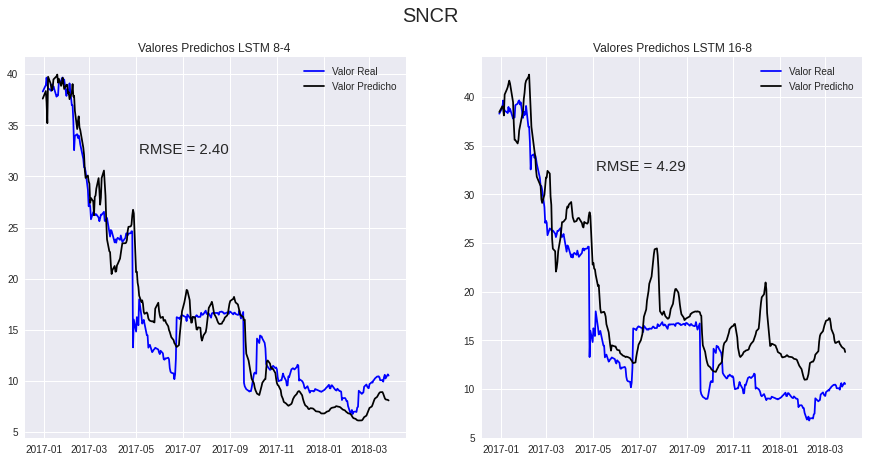

In [14]:
fig, axes = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la LSTM 10-5
axes[0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0].plot(index_time_t,predictedLSTM105, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos LSTM 8-4 ')
axes[0].annotate('RMSE = %.2f'% rmseLSTM105, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos LSTM 16-8')
axes[1].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)




plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [137]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedLSTM105
# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 160, -1.0: 149})


In [138]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      132773        0      0  44.35  42.4567  -1
Valor Final = 132772.56
Ganancia con margen = 32772.56


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [139]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      233283        0          2703      0  44.35  42.4567  -1
Valor Final = 113404.90
Ganancia con margen = 13404.90


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [140]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      174259        0          2019      0  44.35  42.4567  -1
Valor Final = 84716.80
Ganancia con margen = -15283.20


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  